# Machine Learning - Electricity Prices in France and Germany

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import scipy.stats as stats
from time import perf_counter
from tabulate import tabulate

## Import data

In [2]:
dataset = pd.read_csv('data/dataset.csv')
target_results = pd.read_csv('data/target.csv')
originalDataNew = pd.read_csv('data/eval.csv')

In [3]:
# Merge X and Y

df = pd.merge(dataset, target_results, on='ID')


## Data Preparation


In [4]:
# Remove unnecessary columns

df.drop(['ID'], axis=1, inplace=True)

In [5]:
# Print and Remove duplicated values

print(df.duplicated().sum())
df.drop_duplicates()


0


DAY_ID COUNTRY  DE_CONSUMPTION  FR_CONSUMPTION  DE_FR_EXCHANGE  \
0        206      FR        0.210099       -0.427458       -0.606523   
1        501      FR       -0.022399       -1.003452       -0.022063   
2        687      FR        1.395035        1.978665        1.021305   
3        720      DE       -0.983324       -0.849198       -0.839586   
4        818      FR        0.143807       -0.617038       -0.924990   
...      ...     ...             ...             ...             ...   
1489     809      DE        1.529204        1.106682       -1.855327   
1490     887      FR        1.618582        1.752840        0.611392   
1491    1083      DE        0.856399        0.489199       -0.255778   
1492    1133      FR        0.560689       -0.343777       -0.830239   
1493    1118      DE        0.226730       -0.711005        0.873016   

      FR_DE_EXCHANGE  DE_NET_EXPORT  FR_NET_EXPORT  DE_NET_IMPORT  \
0           0.606523            NaN       0.692860            NaN   
1           0.022063      -0.573520      -1.130838       0.573520   
2          -1.021305      -0.622021      -1.682587       0.622021   
3           0.839586      -0.270870       0.563230       0.270870   
4           0.924990            NaN       0.990324            NaN   
...              ...            ...            ...            ...   
1489        1.855327      -0.218658       1.450426       0.218658   
1490       -0.611392       0.449153      -0.152146      -0.449153   
1491        0.255778      -1.531544      -0.829568       1.531544   
1492        0.830239      -0.304856       1.210230       0.304856   
1493       -0.873016       0.296651      -1.547075      -0.296651   

      FR_NET_IMPORT  ...   DE_RAIN   FR_RAIN   DE_WIND   FR_WIND   DE_TEMP  \
0         -0.692860  ... -0.172680 -0.556356 -0.790823 -0.283160 -1.069070   
1          1.130838  ... -1.240300 -0.770457  1.522331  0.828412  0.437419   
2          1.682587  ... -0.480700 -0.313338  0.431134  0.487608  0.684884   
3         -0.563230  ... -1.114838 -0.507570 -0.499409 -0.236249  0.350938   
4         -0.990324  ... -0.541465 -0.424550 -1.088158 -1.011560  0.614338   
...             ...  ...       ...       ...       ...       ...       ...   
1489      -1.450426  ...       NaN       NaN       NaN       NaN       NaN   
1490       0.152146  ...       NaN       NaN       NaN       NaN       NaN   
1491       0.829568  ...  0.207905  0.404763 -0.594595  0.894011  0.256338   
1492      -1.210230  ... -0.682815 -0.390304 -0.972088 -1.501930  1.215528   
1493       1.547075  ... -0.757347 -0.744355 -0.482286 -0.941070 -0.120703   

       FR_TEMP   GAS_RET  COAL_RET  CARBON_RET    TARGET  
0    -0.063404  0.339041  0.124552   -0.002445  0.028313  
1     1.831241 -0.659091  0.047114   -0.490365 -0.112516  
2     0.114836  0.535974  0.743338    0.204952 -0.180840  
3    -0.417514  0.911652 -0.296168    1.073948 -0.260356  
4     0.729495  0.245109  1.526606    2.614378 -0.071733  
...        ...       ...       ...         ...       ...  
1489       NaN  0.876984  0.819520    1.320373 -0.172597  
1490       NaN  0.932633 -0.085690    0.356356 -0.063546  
1491  0.402316 -1.112899 -0.237835    0.067152  0.151797  
1492  1.338708  0.962812 -5.392852   -0.843812 -0.640917  
1493  0.391491  1.059829 -0.326640   -0.566724 -0.252764  

[1494 rows x 35 columns]

In [6]:
# Interpolate missing values 

df.sort_values(by=['COUNTRY', 'DAY_ID'], inplace=True)
df.interpolate(method='linear', limit_direction='both', limit=2, inplace=True)


/var/folders/kb/sh6xl4v90jn6mlvsm5cn4jmm0000gn/T/ipykernel_25690/906090579.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', limit_direction='both', limit=2, inplace=True)


In [7]:
# Label encoding

le = LabelEncoder()
le.fit(['FR', 'DE'])
df['COUNTRY'] = le.transform(df['COUNTRY'])


df.head()

DAY_ID  COUNTRY  DE_CONSUMPTION  FR_CONSUMPTION  DE_FR_EXCHANGE  \
1468       2        0       -0.068972       -0.667390       -1.102015   
680        3        0       -0.134670       -0.834564       -1.051716   
991        5        0       -0.297850       -0.470371        0.144615   
1356       7        0        0.057599       -0.625625        0.002239   
713        8        0       -0.282744       -0.700027        1.309253   

      FR_DE_EXCHANGE  DE_NET_EXPORT  FR_NET_EXPORT  DE_NET_IMPORT  \
1468        1.102015      -1.080403       0.256736       1.080403   
680         1.051716      -1.881881      -0.612133       1.881881   
991        -0.144615      -1.208286      -1.811403       1.208286   
1356       -0.002239      -0.676226      -0.745182       0.676226   
713        -1.309253       0.248085      -2.226840      -0.248085   

      FR_NET_IMPORT  ...   DE_RAIN   FR_RAIN   DE_WIND   FR_WIND   DE_TEMP  \
1468      -0.256736  ... -0.344600 -0.372156 -0.623041 -0.926064 -0.148950   
680        0.612133  ... -1.394561 -1.118297  0.244859  0.488650 -1.710888   
991        1.811403  ... -1.374757 -0.790071  0.333817  0.021868 -0.062187   
1356       0.745182  ... -0.531862 -0.663419  0.098940  1.367421 -0.812164   
713        2.226840  ...  1.522720 -0.307449  1.690497  1.584210 -0.441943   

       FR_TEMP   GAS_RET  COAL_RET  CARBON_RET    TARGET  
1468  0.641235  1.802550  1.140920    0.900434  0.861270  
680  -0.951057  0.440121 -0.064550   -0.032756  7.138604  
991   1.459745 -0.117977  0.550433    0.781870  0.026374  
1356  0.954384 -0.379980  0.518459   -0.034642 -0.021227  
713  -0.382423  1.557325  0.146634    2.329924  0.042996  

[5 rows x 35 columns]

In [8]:
# Scale data
sc = StandardScaler()
df_standard = pd.DataFrame(sc.fit_transform(df), columns=df.columns)


## Data Exploration

In [9]:
# Shape
print(df.shape)

(1494, 35)


In [10]:
# List columns
print(df.columns)

Index(['DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT',
       'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET',
       'TARGET'],
      dtype='object')


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1494 entries, 1468 to 1437
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DAY_ID            1494 non-null   int64  
 1   COUNTRY           1494 non-null   int64  
 2   DE_CONSUMPTION    1494 non-null   float64
 3   FR_CONSUMPTION    1494 non-null   float64
 4   DE_FR_EXCHANGE    1494 non-null   float64
 5   FR_DE_EXCHANGE    1494 non-null   float64
 6   DE_NET_EXPORT     1494 non-null   float64
 7   FR_NET_EXPORT     1494 non-null   float64
 8   DE_NET_IMPORT     1494 non-null   float64
 9   FR_NET_IMPORT     1494 non-null   float64
 10  DE_GAS            1494 non-null   float64
 11  FR_GAS            1494 non-null   float64
 12  DE_COAL           1494 non-null   float64
 13  FR_COAL           1494 non-null   float64
 14  DE_HYDRO          1494 non-null   float64
 15  FR_HYDRO          1494 non-null   float64
 16  DE_NUCLEAR        1494 non-null   float64
 1

In [12]:
# Describe data
df_standard.describe()

DAY_ID      COUNTRY  DE_CONSUMPTION  FR_CONSUMPTION  \
count  1.494000e+03  1494.000000    1.494000e+03    1.494000e+03   
mean  -1.521912e-16     0.000000   -9.987548e-17    2.377988e-17   
std    1.000335e+00     1.000335    1.000335e+00    1.000335e+00   
min   -1.715791e+00    -1.150428   -4.000386e+00   -1.569977e+00   
25%   -8.685660e-01    -1.150428   -6.905414e-01   -7.584076e-01   
50%   -2.497310e-03     0.869242   -1.045481e-01   -4.072487e-01   
75%    8.519755e-01     0.869242    7.347372e-01    7.299161e-01   
max    1.806463e+00     0.869242    2.386278e+00    3.614582e+00   

       DE_FR_EXCHANGE  FR_DE_EXCHANGE  DE_NET_EXPORT  FR_NET_EXPORT  \
count    1.494000e+03    1.494000e+03   1.494000e+03    1494.000000   
mean    -3.329183e-17    3.329183e-17  -2.853585e-17       0.000000   
std      1.000335e+00    1.000335e+00   1.000335e+00       1.000335   
min     -2.809134e+00   -2.879410e+00  -2.356851e+00      -2.601024   
25%     -7.515584e-01   -8.105536e-01  -7.373519e-01      -0.731476   
50%     -1.159402e-02    1.159402e-02  -5.072478e-02       0.158106   
75%      8.105536e-01    7.515584e-01   7.264098e-01       0.804051   
max      2.879410e+00    2.809134e+00   2.699679e+00       1.905268   

       DE_NET_IMPORT  FR_NET_IMPORT  ...       DE_RAIN       FR_RAIN  \
count   1.494000e+03    1494.000000  ...  1.494000e+03  1.494000e+03   
mean    2.853585e-17       0.000000  ... -8.322957e-18  4.755975e-18   
std     1.000335e+00       1.000335  ...  1.000335e+00  1.000335e+00   
min    -2.699679e+00      -1.905268  ... -2.155493e+00 -1.679567e+00   
25%    -7.264098e-01      -0.804051  ... -6.165291e-01 -5.054381e-01   
50%     5.072478e-02      -0.158106  ... -2.415867e-01 -2.364596e-01   
75%     7.373519e-01       0.731476  ...  3.855620e-01  1.472742e-01   
max     2.356851e+00       2.601024  ...  8.037280e+00  9.025110e+00   

            DE_WIND      FR_WIND       DE_TEMP       FR_TEMP       GAS_RET  \
count  1.494000e+03  1494.000000  1.494000e+03  1.494000e+03  1.494000e+03   
mean   1.902390e-17     0.000000 -1.188994e-18 -7.133963e-18 -1.188994e-17   
std    1.000335e+00     1.000335  1.000335e+00  1.000335e+00  1.000335e+00   
min   -1.917516e+00    -1.947303 -4.786964e+00 -5.887821e+00 -4.927635e+00   
25%   -7.247088e-01    -0.763924 -6.388131e-01 -6.605772e-01 -6.218004e-01   
50%   -3.469392e-01    -0.315199 -2.052686e-02 -2.417165e-02 -4.522761e-02   
75%    4.855368e-01     0.662950  6.370532e-01  6.877723e-01  5.634120e-01   
max    4.785133e+00     4.638152  2.985355e+00  2.849357e+00  5.118143e+00   

           COAL_RET    CARBON_RET       TARGET  
count  1.494000e+03  1.494000e+03  1494.000000  
mean   1.397068e-17  4.755975e-18     0.000000  
std    1.000335e+00  1.000335e+00     1.000335  
min   -5.581159e+00 -3.972022e+00    -6.390420  
25%   -5.029115e-01 -5.494878e-01    -0.299540  
50%    1.536492e-03 -2.408796e-02    -0.086957  
75%    5.609268e-01  4.721875e-01     0.173834  
max    3.565386e+00  4.908968e+00     7.441865  

[8 rows x 35 columns]

In [13]:
# Variance
df.var()

DAY_ID              119069.883670
COUNTRY                  0.245318
DE_CONSUMPTION           0.453483
FR_CONSUMPTION           0.844552
DE_FR_EXCHANGE           0.932616
FR_DE_EXCHANGE           0.932616
DE_NET_EXPORT            0.880969
FR_NET_EXPORT            1.124436
DE_NET_IMPORT            0.880969
FR_NET_IMPORT            1.124436
DE_GAS                   0.722823
FR_GAS                   0.821742
DE_COAL                  0.717892
FR_COAL                  0.256179
DE_HYDRO                 1.180113
FR_HYDRO                 1.119082
DE_NUCLEAR               0.814449
FR_NUCLEAR               0.930343
DE_SOLAR                 1.144683
FR_SOLAR                 1.165100
DE_WINDPOW               1.132494
FR_WINDPOW               1.414682
DE_LIGNITE               0.724778
DE_RESIDUAL_LOAD         0.725051
FR_RESIDUAL_LOAD         0.803398
DE_RAIN                  0.941085
FR_RAIN                  1.095343
DE_WIND                  1.080862
FR_WIND                  1.085954
DE_TEMP       

In [14]:
# Print target mean by country

print(df.groupby('COUNTRY')['TARGET'].mean())

COUNTRY
0    0.148044
1    0.046026
Name: TARGET, dtype: float64


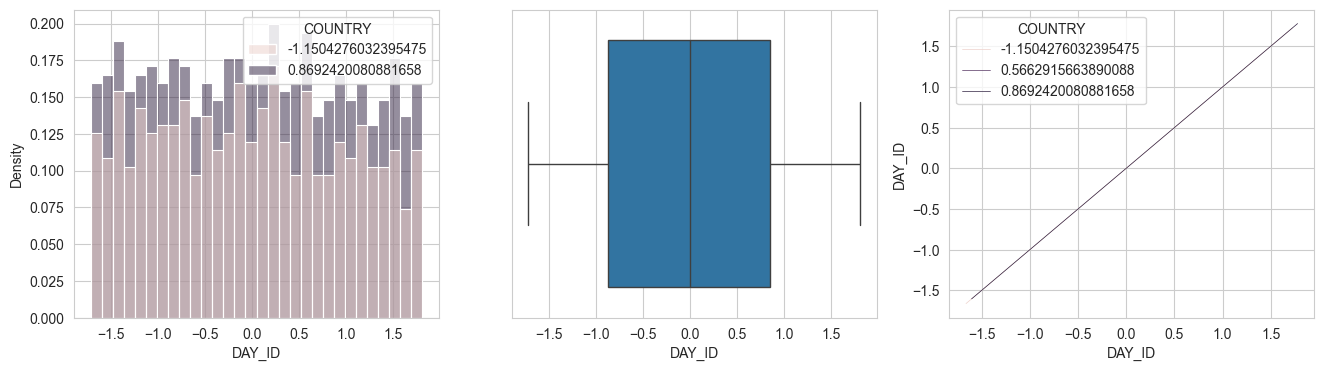

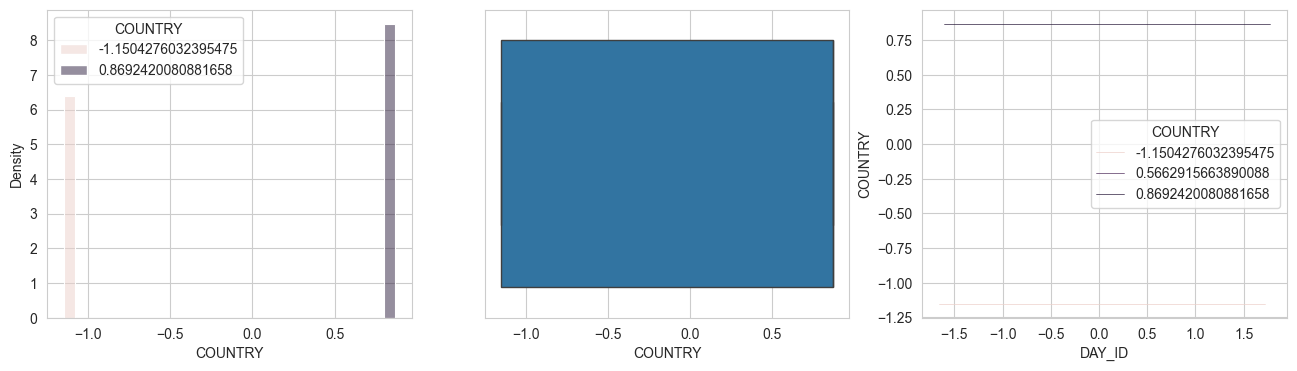

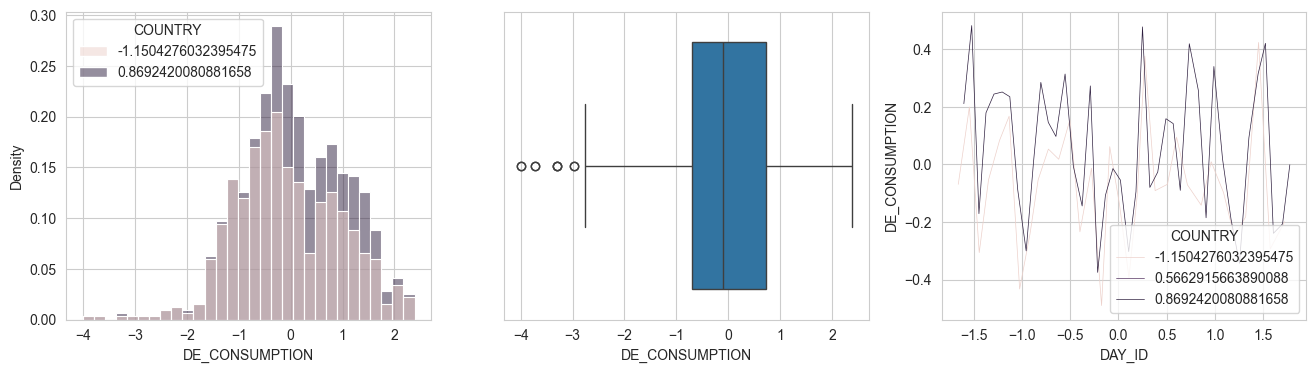

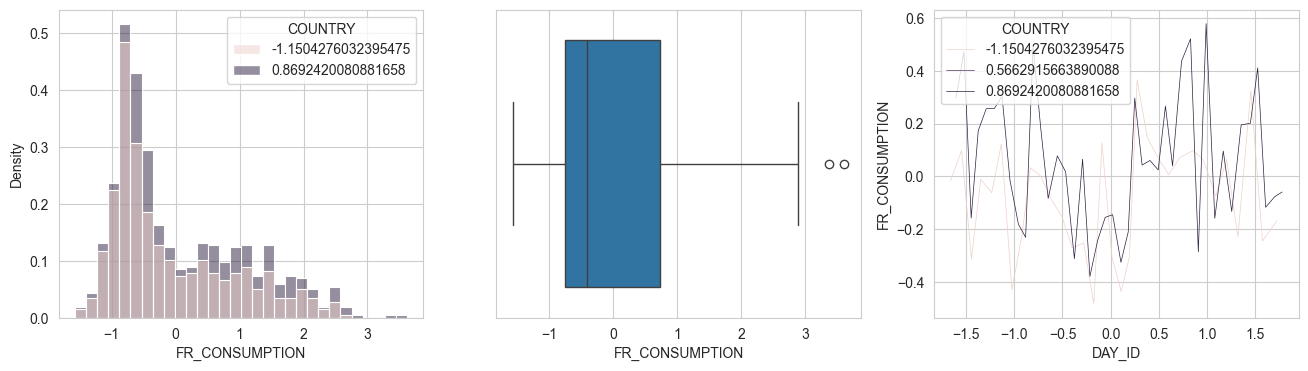

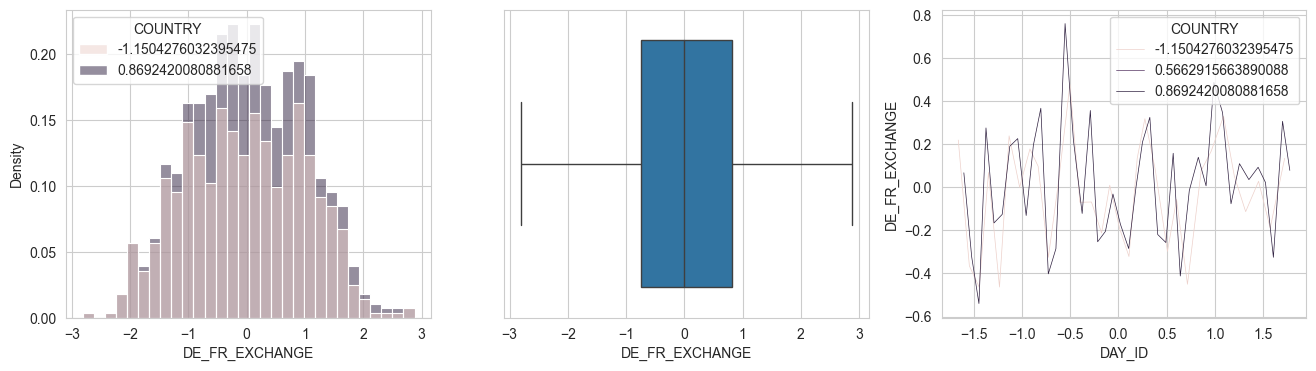

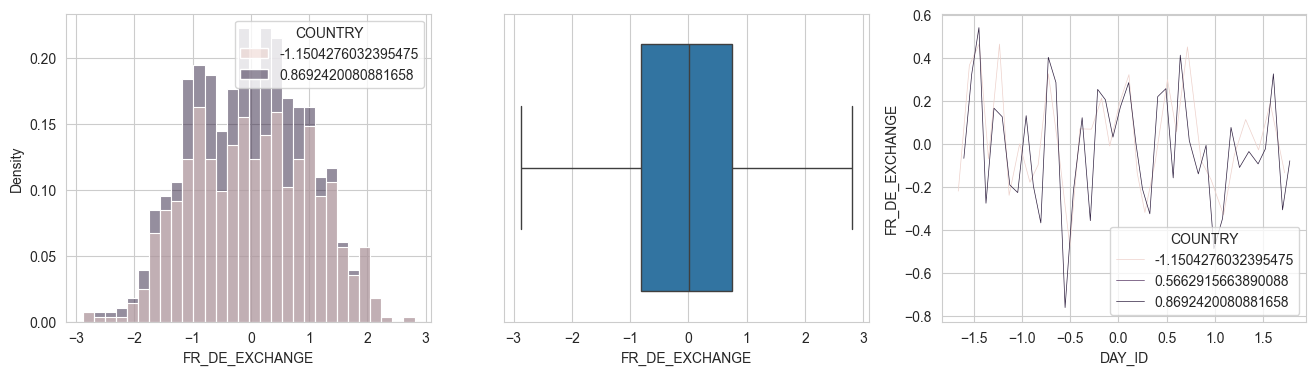

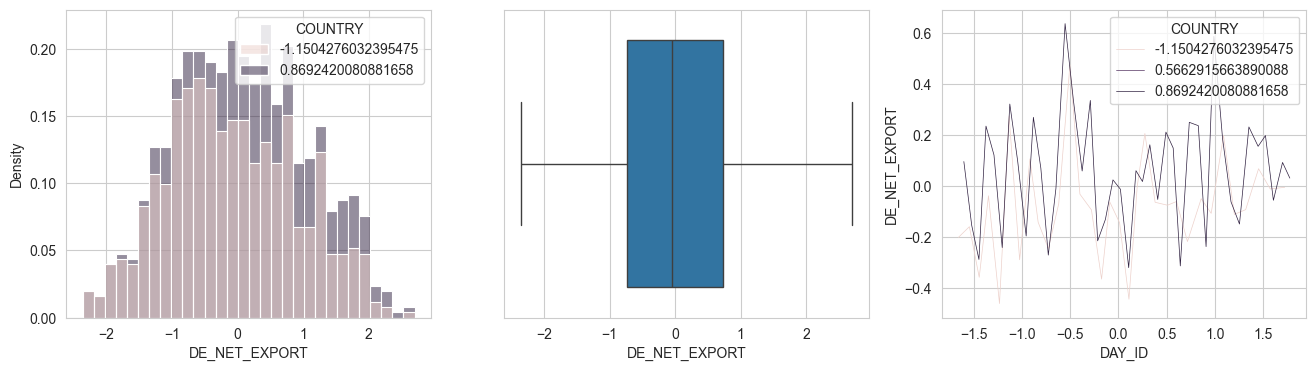

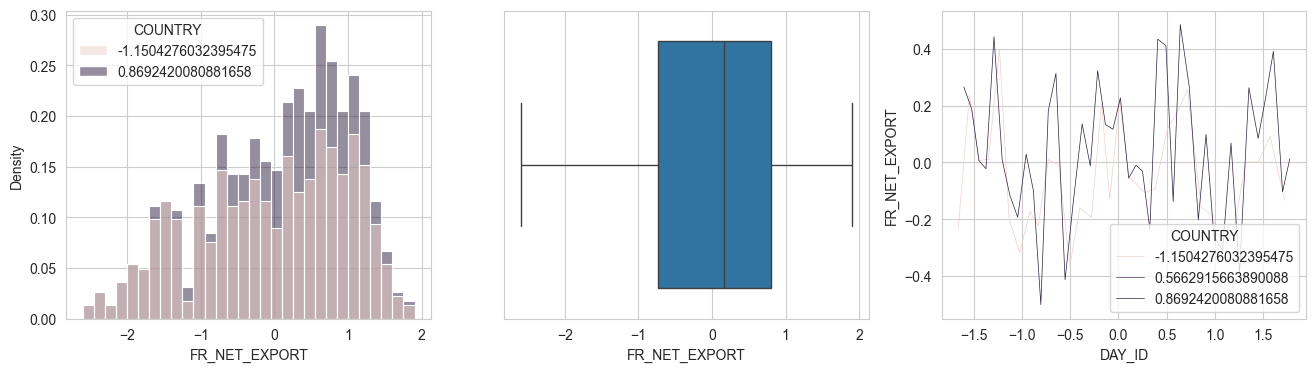

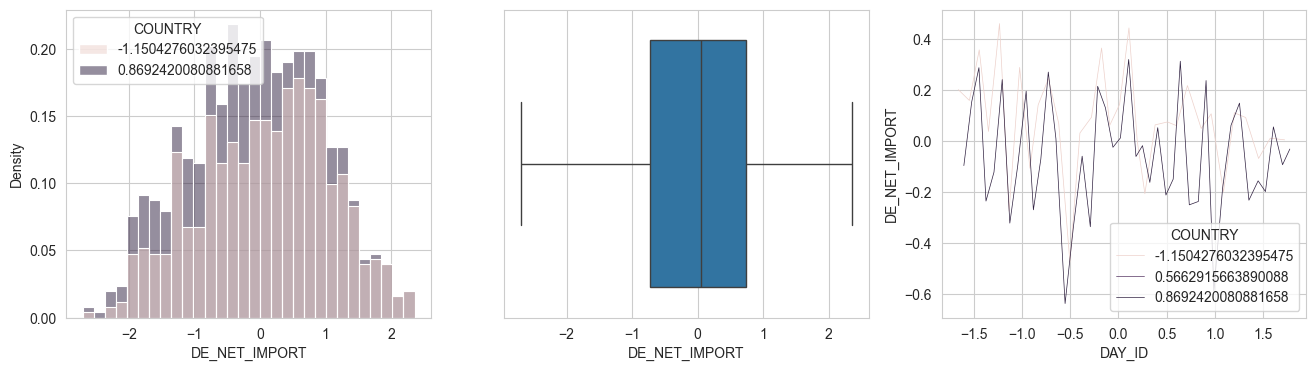

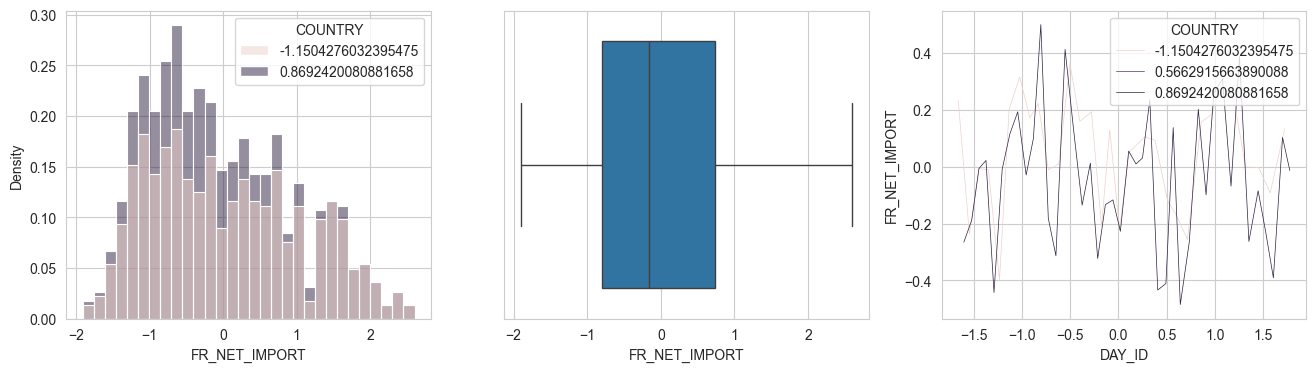

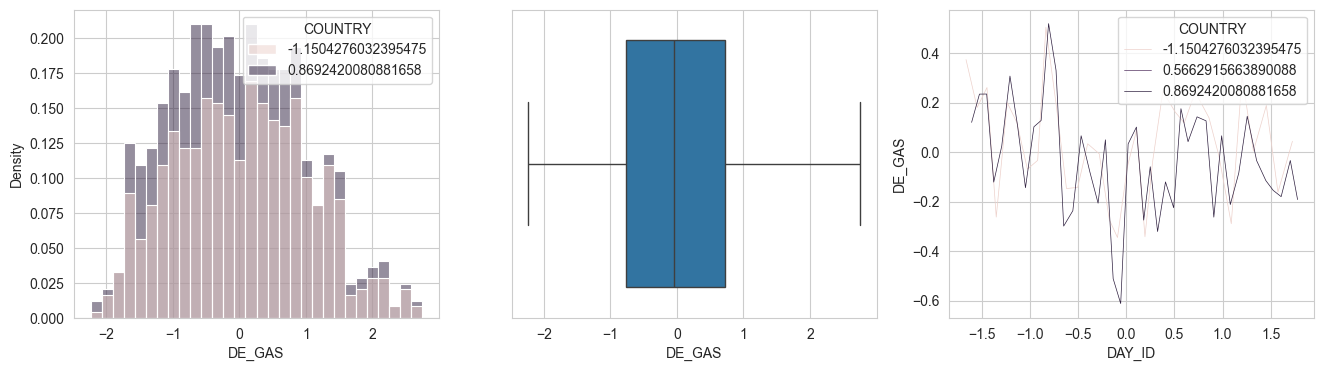

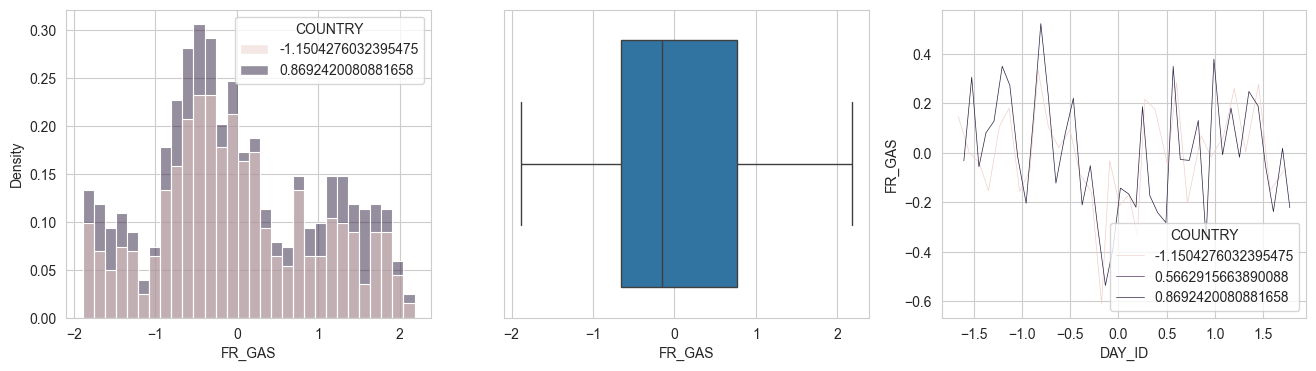

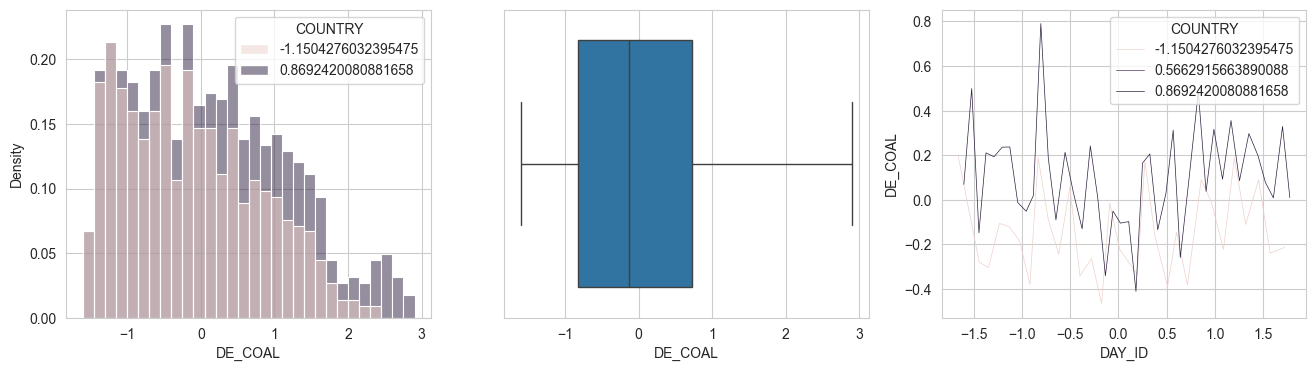

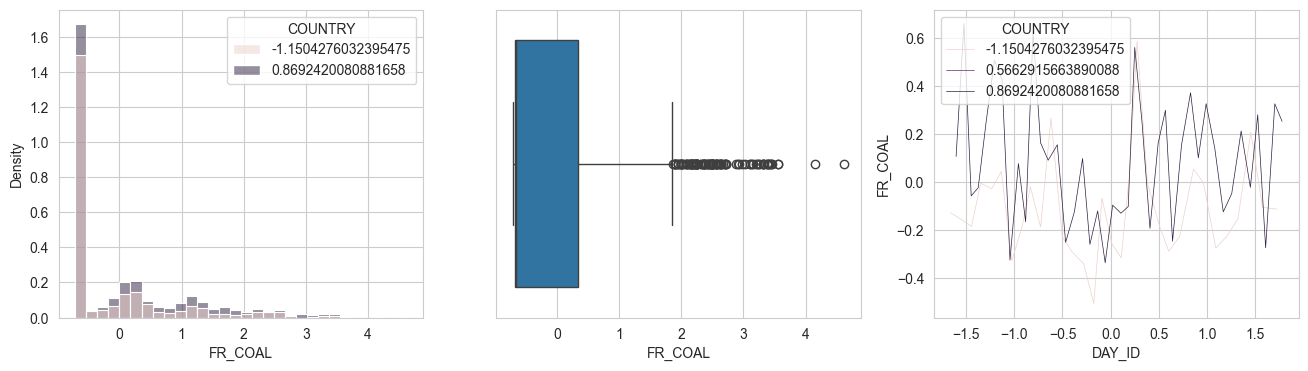

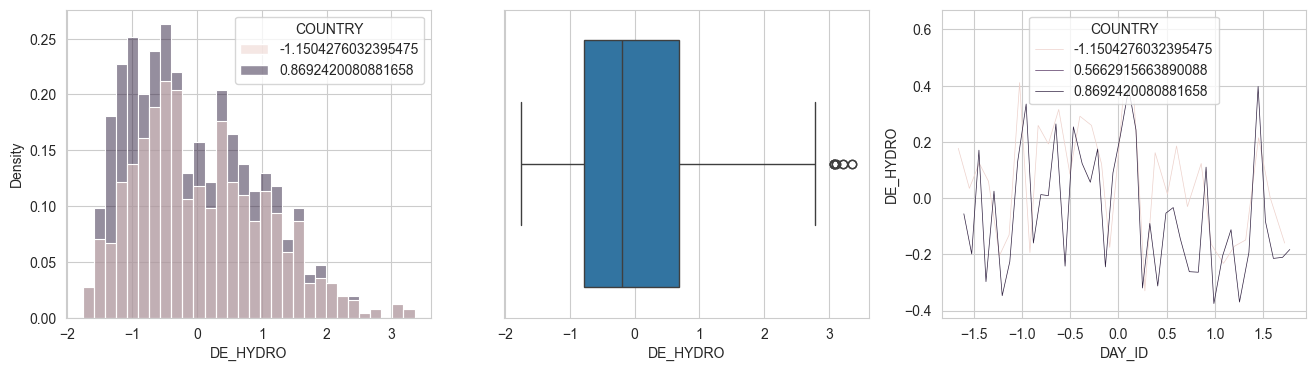

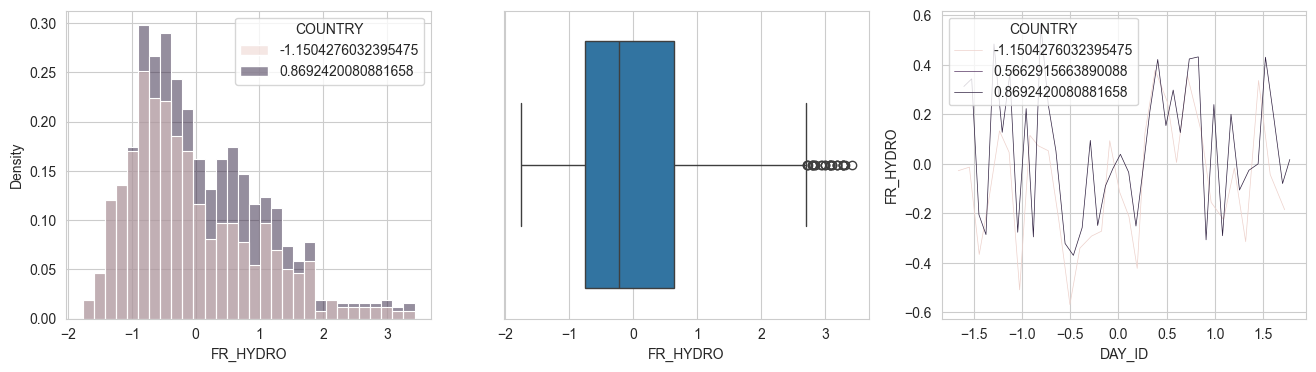

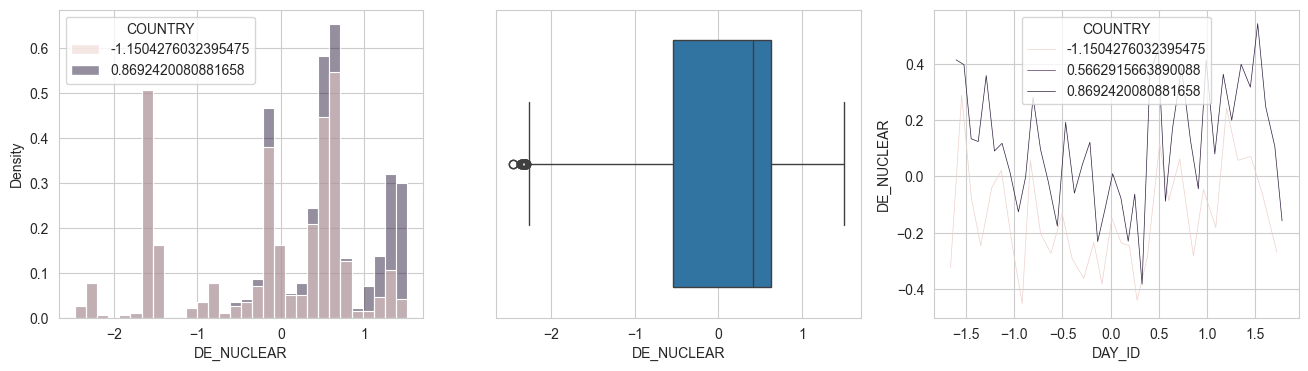

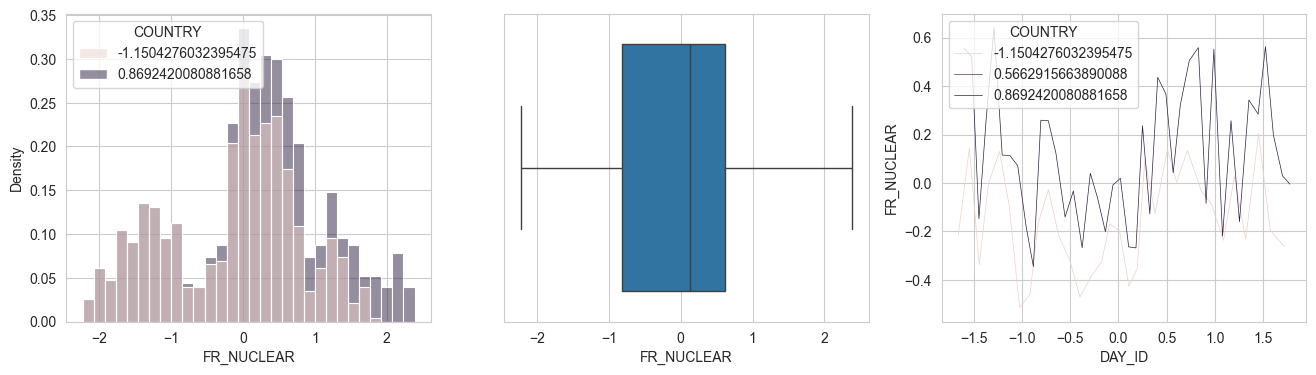

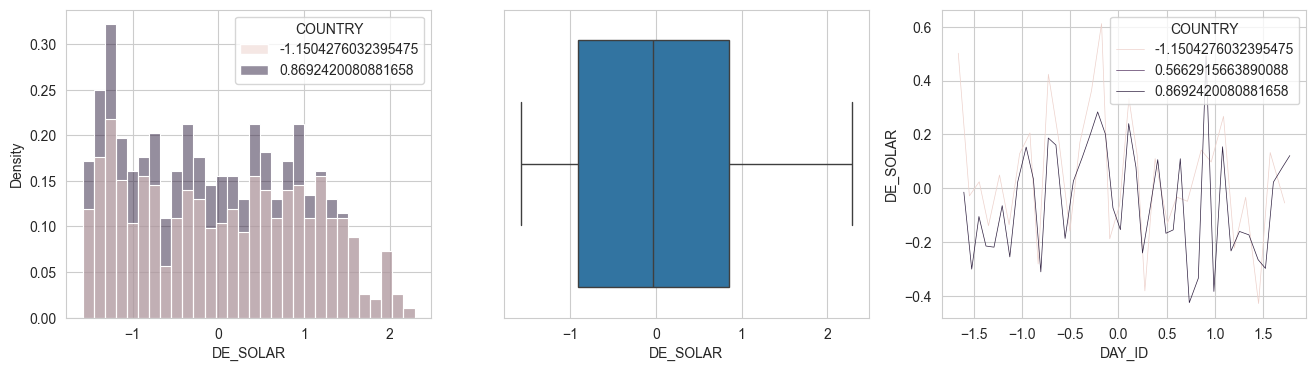

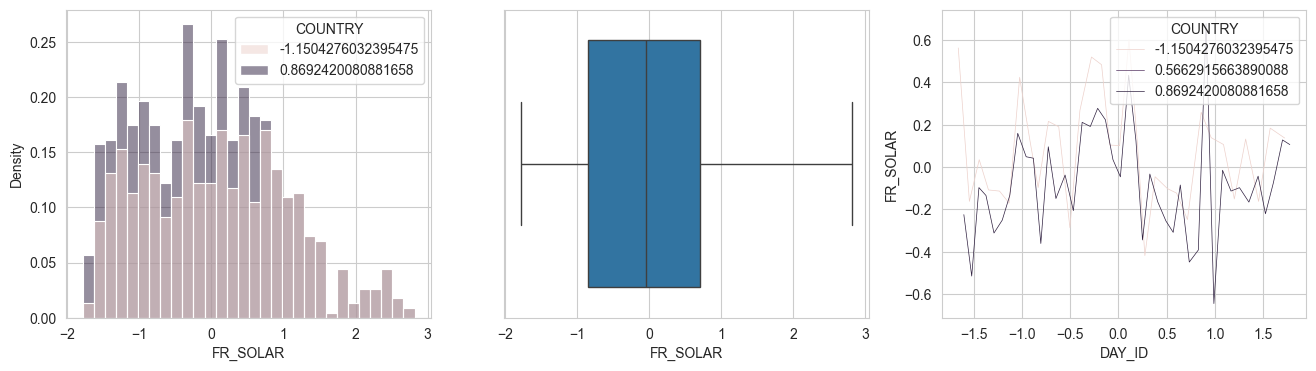

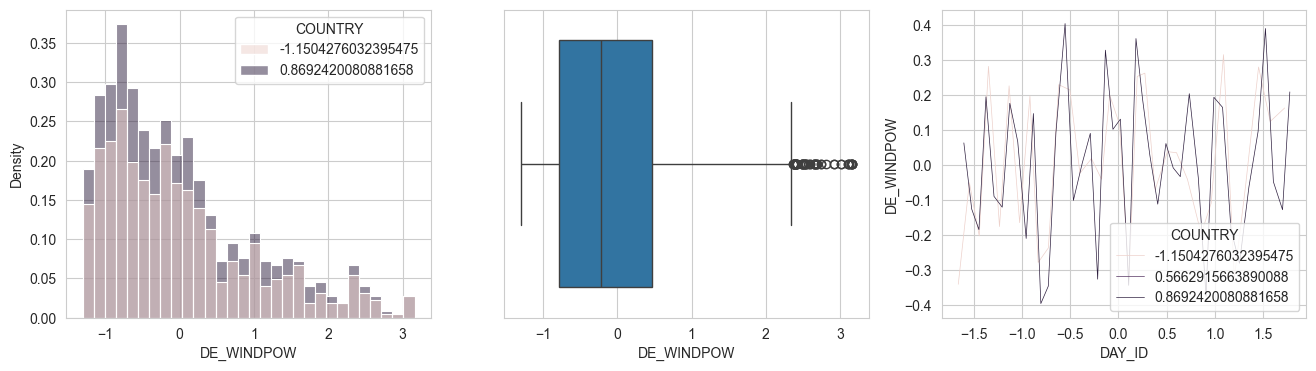

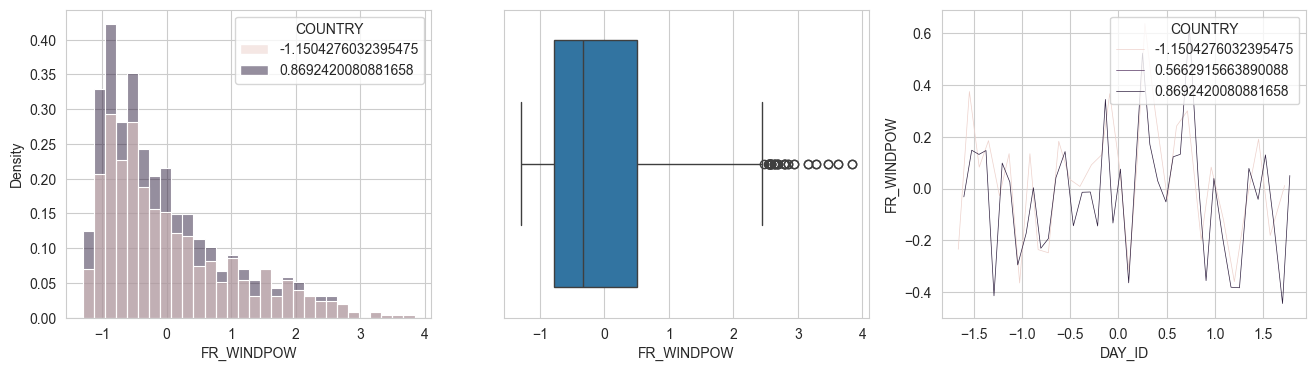

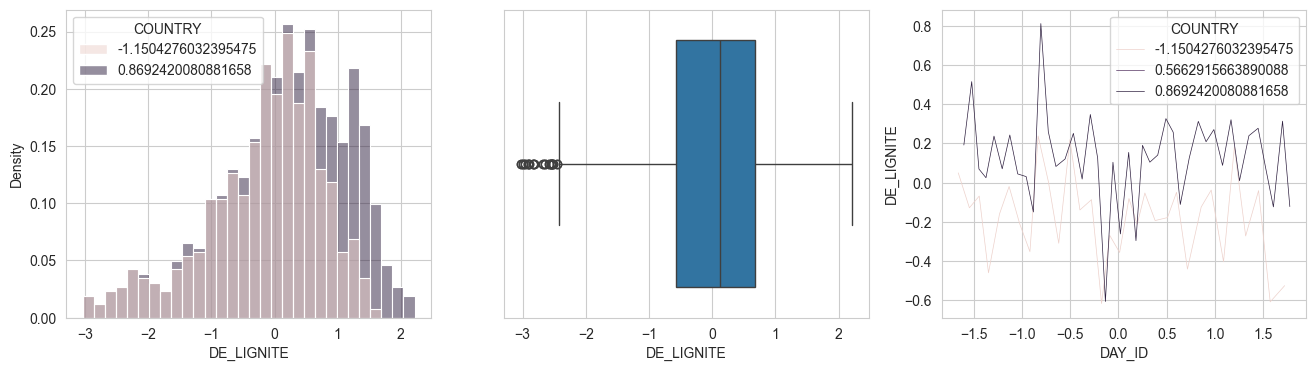

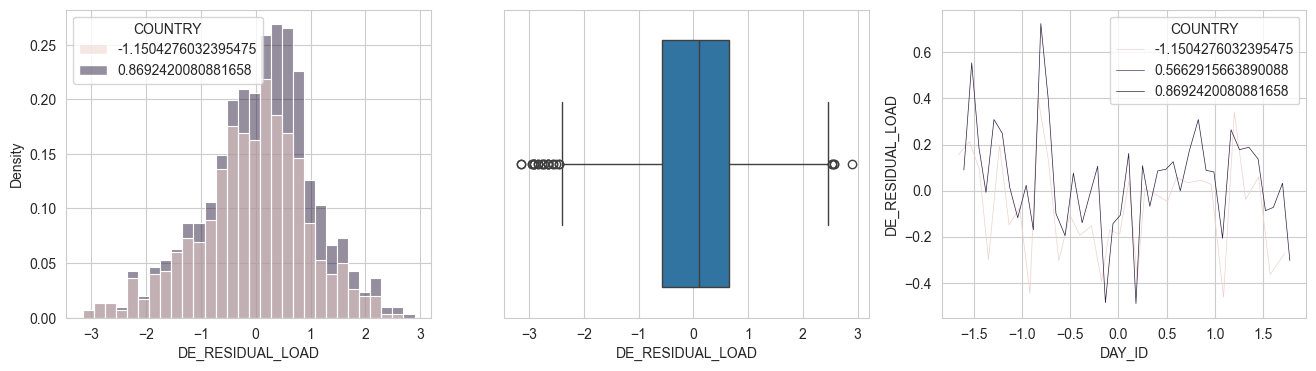

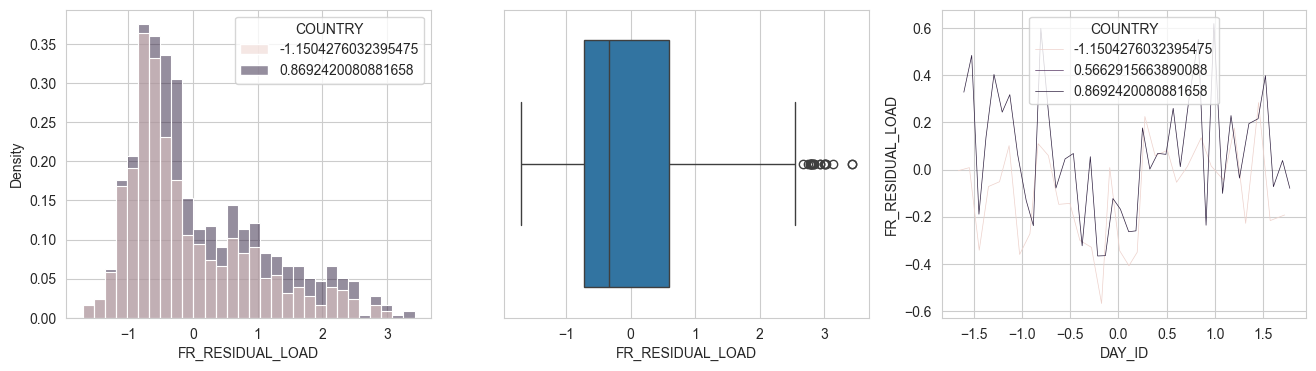

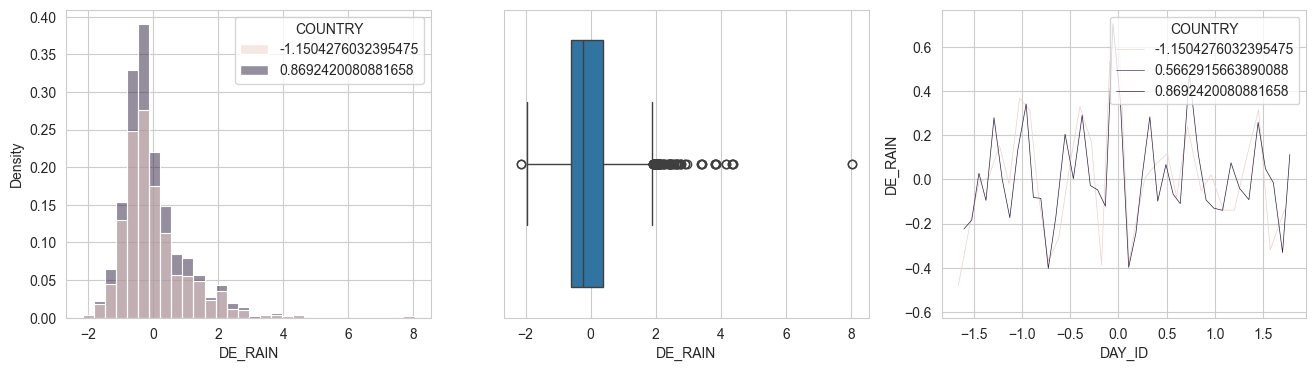

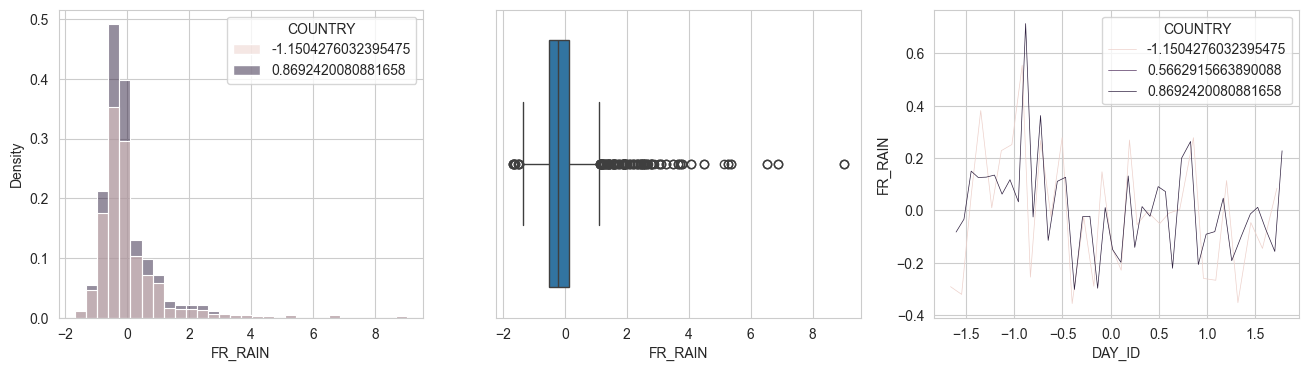

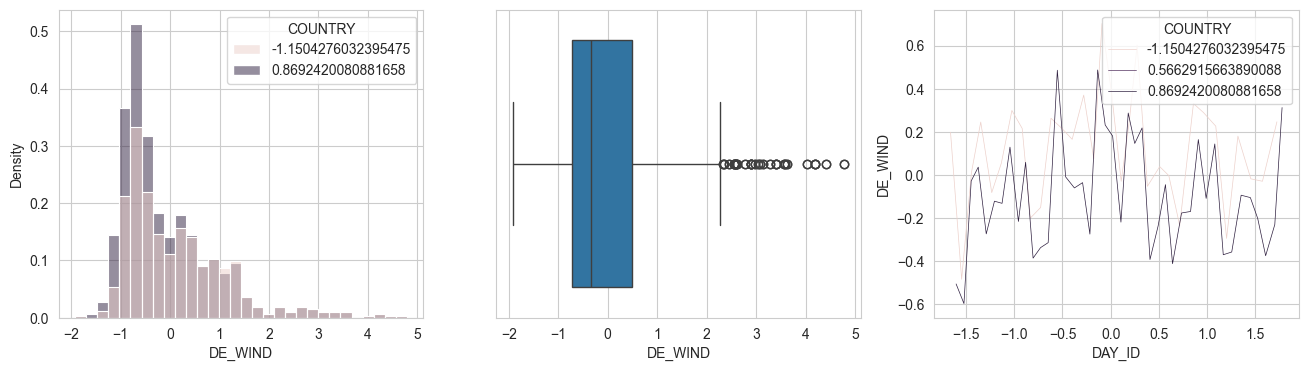

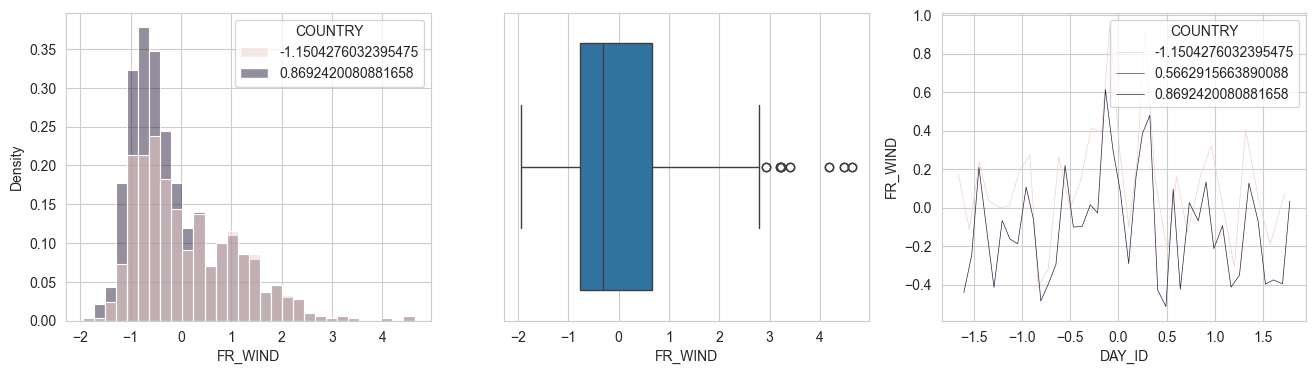

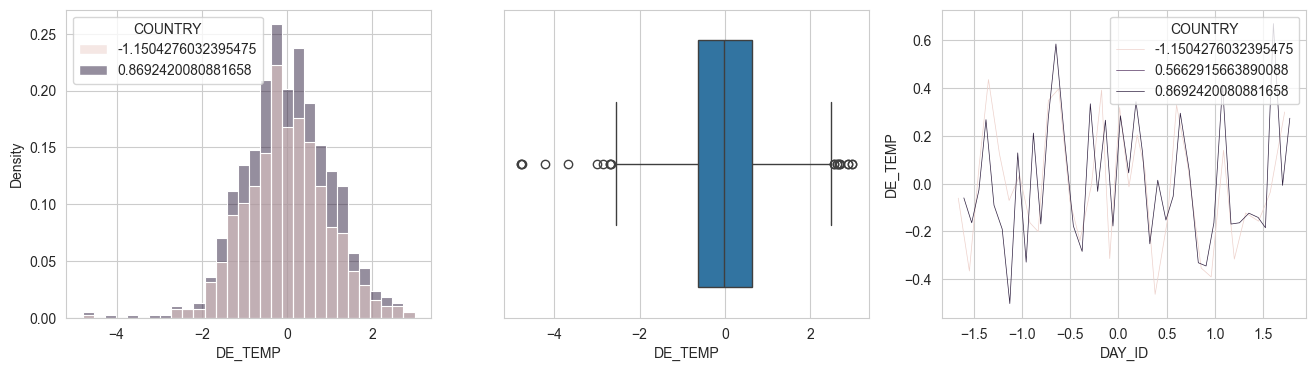

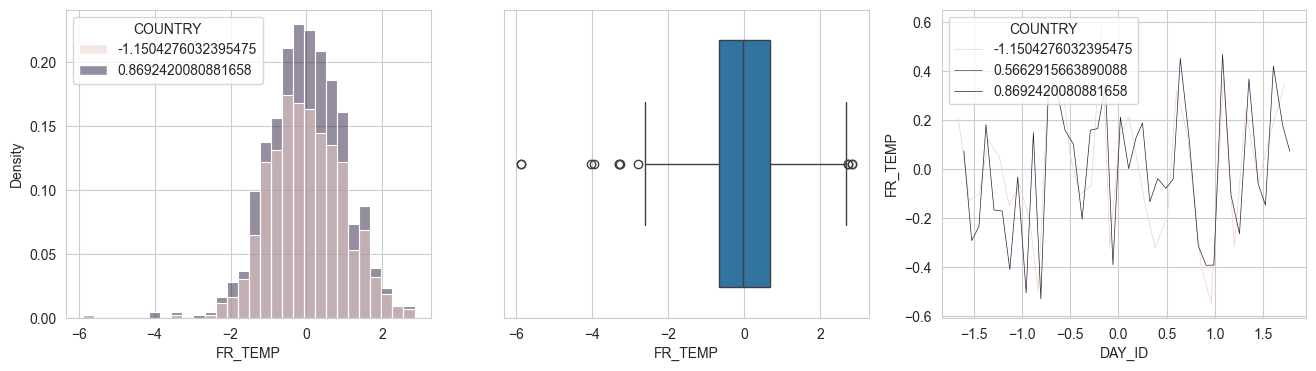

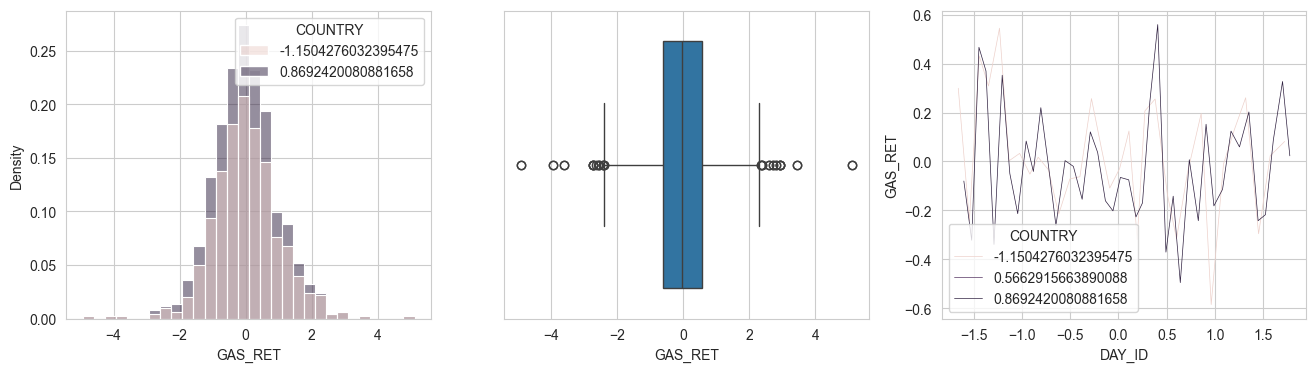

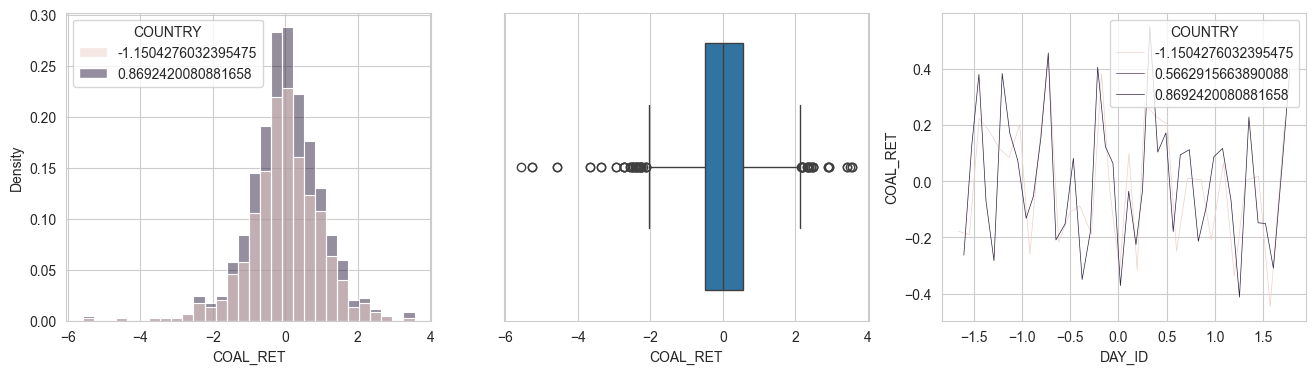

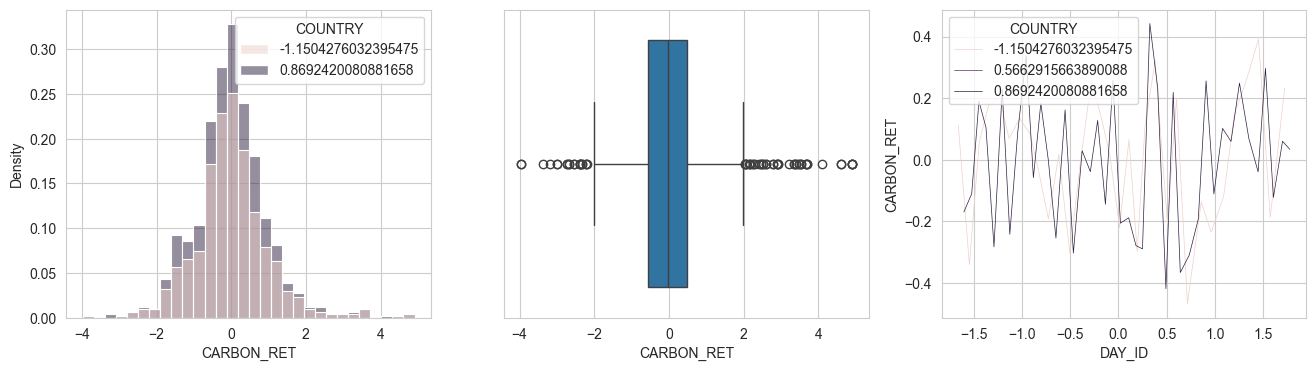

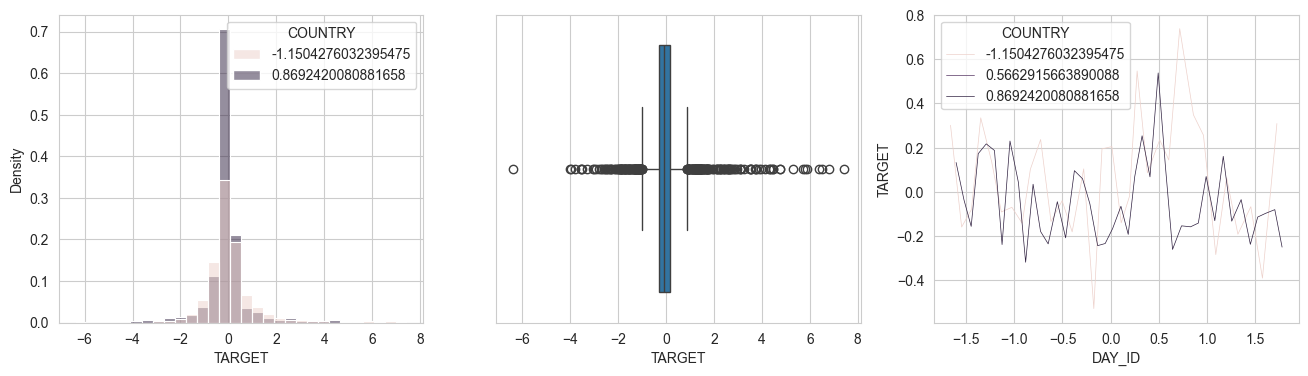

In [15]:
# Plot the density by country, boxplot and evolotion of each columns

df.sort_values(by=['COUNTRY', 'DAY_ID'], inplace=True)

for i, col in enumerate(df_standard.columns):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    sns.histplot(x=col, hue='COUNTRY', data=df_standard, bins=30, stat="density", ax=axes[0])
    sns.boxplot(x=col, data=df_standard, ax=axes[1])
    sns.lineplot(x='DAY_ID', y=col, data=df_standard.groupby(df_standard.index//20).mean(), ax=axes[2], linewidth=0.5, hue='COUNTRY')
    plt.show()


In [16]:
# Number of outliers by column

outliers = []

for col in df_standard.columns:
    outliers.append((col, len(df_standard[(np.abs(stats.zscore(df_standard[col])) > 3)])))

outliers.sort(key=lambda x: x[1], reverse=True)

print(tabulate(outliers, headers=['Column', 'Number of outliers'], tablefmt='orgtbl'))

| Column           |   Number of outliers |
|------------------+----------------------|
| TARGET           |                   38 |
| FR_RAIN          |                   29 |
| DE_WIND          |                   28 |
| CARBON_RET       |                   26 |
| FR_COAL          |                   25 |
| FR_HYDRO         |                   17 |
| DE_RAIN          |                   17 |
| COAL_RET         |                   14 |
| DE_WINDPOW       |                   12 |
| FR_WIND          |                   12 |
| DE_HYDRO         |                   10 |
| FR_WINDPOW       |                   10 |
| GAS_RET          |                   10 |
| DE_CONSUMPTION   |                    7 |
| FR_TEMP          |                    7 |
| FR_RESIDUAL_LOAD |                    6 |
| DE_TEMP          |                    6 |
| FR_CONSUMPTION   |                    2 |
| DE_LIGNITE       |                    2 |
| DE_RESIDUAL_LOAD |                    2 |
| DAY_ID           |            

<Axes: >

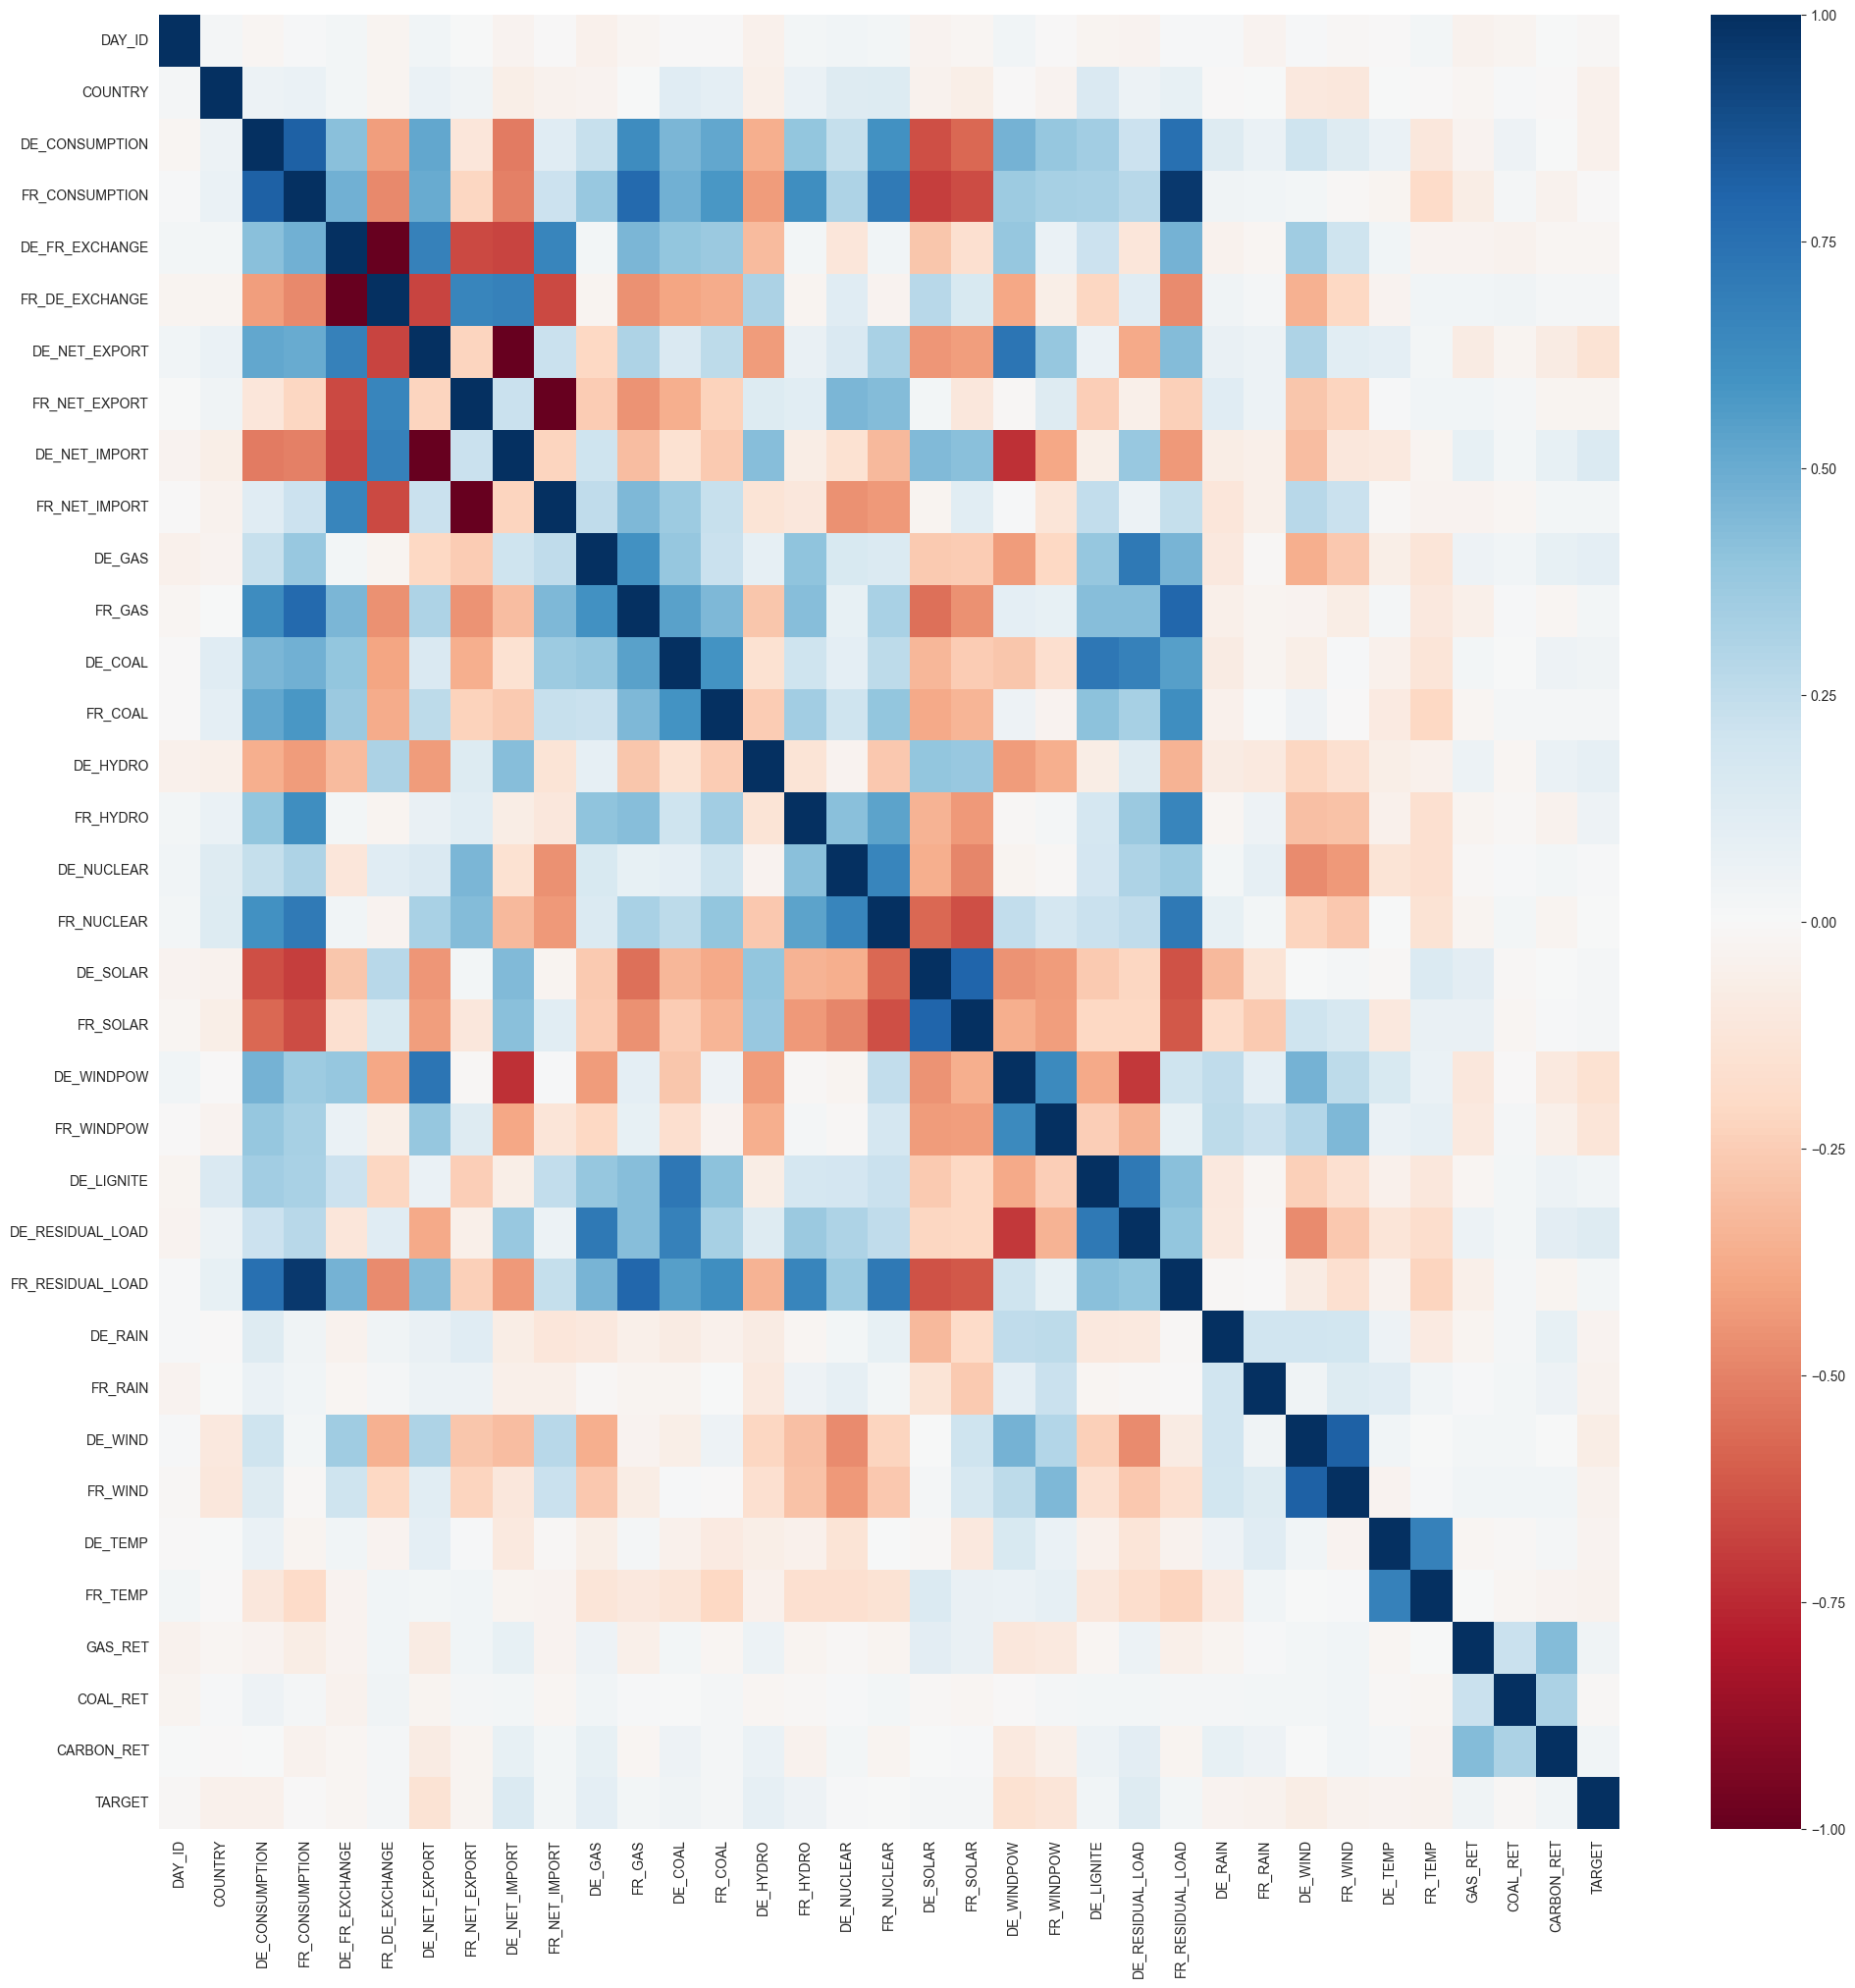

In [17]:
# Plot correlation matrix with heatmap

plt.figure(figsize=(24, 24))
sns.heatmap(df_standard.corr(), vmin=-1, vmax=1, cmap='RdBu')

## Data Setup and Correction

In [18]:
# Scale data with RobustScaler

sc = StandardScaler()
# sc = MinMaxScaler()
# sc = PowerTransformer()
# sc = RobustScaler()
# sc = QuantileTransformer()
# sc = QuantileTransformer(output_distribution='normal')

df_scaled = pd.DataFrame(sc.fit_transform(df), columns=df.columns)

In [19]:
# Print each column correlation with each other
treashold = 0.75
variable_seen = []
highest_correlation = []
for i in df_scaled.columns:
    for j in df_scaled.columns:
        if (i, j) not in variable_seen:
            variable_seen += [(j, i)]
            if i != j and i != 'TARGET' and j != 'TARGET' and abs(df_scaled[i].corr(df_scaled[j])) > treashold:
                print("{:>20} <---> {:<20} :  {}".format(i, j, df_scaled[i].corr(df_scaled[j])))
                
                if df_scaled[i].corr(df_scaled['TARGET']) > df_scaled[j].corr(df_scaled['TARGET']):
                    highest_correlation += [j]
                else:
                    highest_correlation += [i]

df_scaled.drop(highest_correlation, axis=1, inplace=True)


      DE_CONSUMPTION <---> FR_CONSUMPTION       :  0.8132017057921065
      DE_CONSUMPTION <---> FR_RESIDUAL_LOAD     :  0.7541421978532968
      FR_CONSUMPTION <---> FR_GAS               :  0.7797271465379948
      FR_CONSUMPTION <---> FR_RESIDUAL_LOAD     :  0.9650862507900652
      DE_FR_EXCHANGE <---> FR_DE_EXCHANGE       :  -1.0
       DE_NET_EXPORT <---> DE_NET_IMPORT        :  -1.0
       FR_NET_EXPORT <---> FR_NET_IMPORT        :  -1.0
              FR_GAS <---> FR_RESIDUAL_LOAD     :  0.7959142919276703
            DE_SOLAR <---> FR_SOLAR             :  0.8033807850273873
             DE_WIND <---> FR_WIND              :  0.8197529213174184


In [20]:
# Split data

X = df_scaled.drop(['TARGET'], axis=1)
y = df_scaled['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=int(perf_counter ()*100), shuffle=True)

train_set = pd.concat([X_train, y_train], axis=1)
test_set = pd.concat([X_test, y_test], axis=1)

In [21]:
# Clip outliers with z-score

# z = np.abs(stats.zscore(train_set, axis=1))

# train_set = train_set[(z < 3).all(axis=1)]

# Clip with outliers with IQR score

Q1 = train_set.quantile(0.25)
Q3 = train_set.quantile(0.75)
IQR = Q3 - Q1
lower_bound_X = Q1 - 1.5 * IQR
upper_bound_X = Q3 + 1.5 * IQR

# train_set = train_set[~((train_set < lower_bound_X) | (train_set > upper_bound_X)).any(axis=1)]
train_set = train_set.clip(lower_bound_X, upper_bound_X, axis=1)

# Log transform

# train_set = np.log(train_set + 1)
# test_set = np.log(test_set + 1)
    

#### Dealing with outliers

In [22]:
# Keep 5 most correlated columns with target column and delete the others

# corr_target = abs(df.corr()['TARGET'])

# print(corr_target.sort_values(ascending=False))

# df = df.drop(corr_target.sort_values(ascending=False)[10:].index, axis=1)

# # Print the 5 most correlated columns with target column


In [23]:
# Delete columns with no correlation with other columns 

# treashold = 0.2
# to_delete = []
# for i in df_scaled.columns:
#     coor = []
#     for j in df_scaled.columns:
#         if i != j and i != 'TARGET' and j != 'TARGET':
#             coor.append(df_scaled[i].corr(df_scaled[j]))

#     # delete max the absolute value of the correlation    
#     if len(coor) > 0 and max(coor) < treashold and min(coor) > -treashold:
#         print(i, max(coor), min(coor))
#         to_delete.append(i)

# df_scaled.drop(to_delete, axis=1, inplace=True)

    

In [24]:
# Print shape of train and test set

print(train_set.shape)


(1195, 27)


<Axes: >

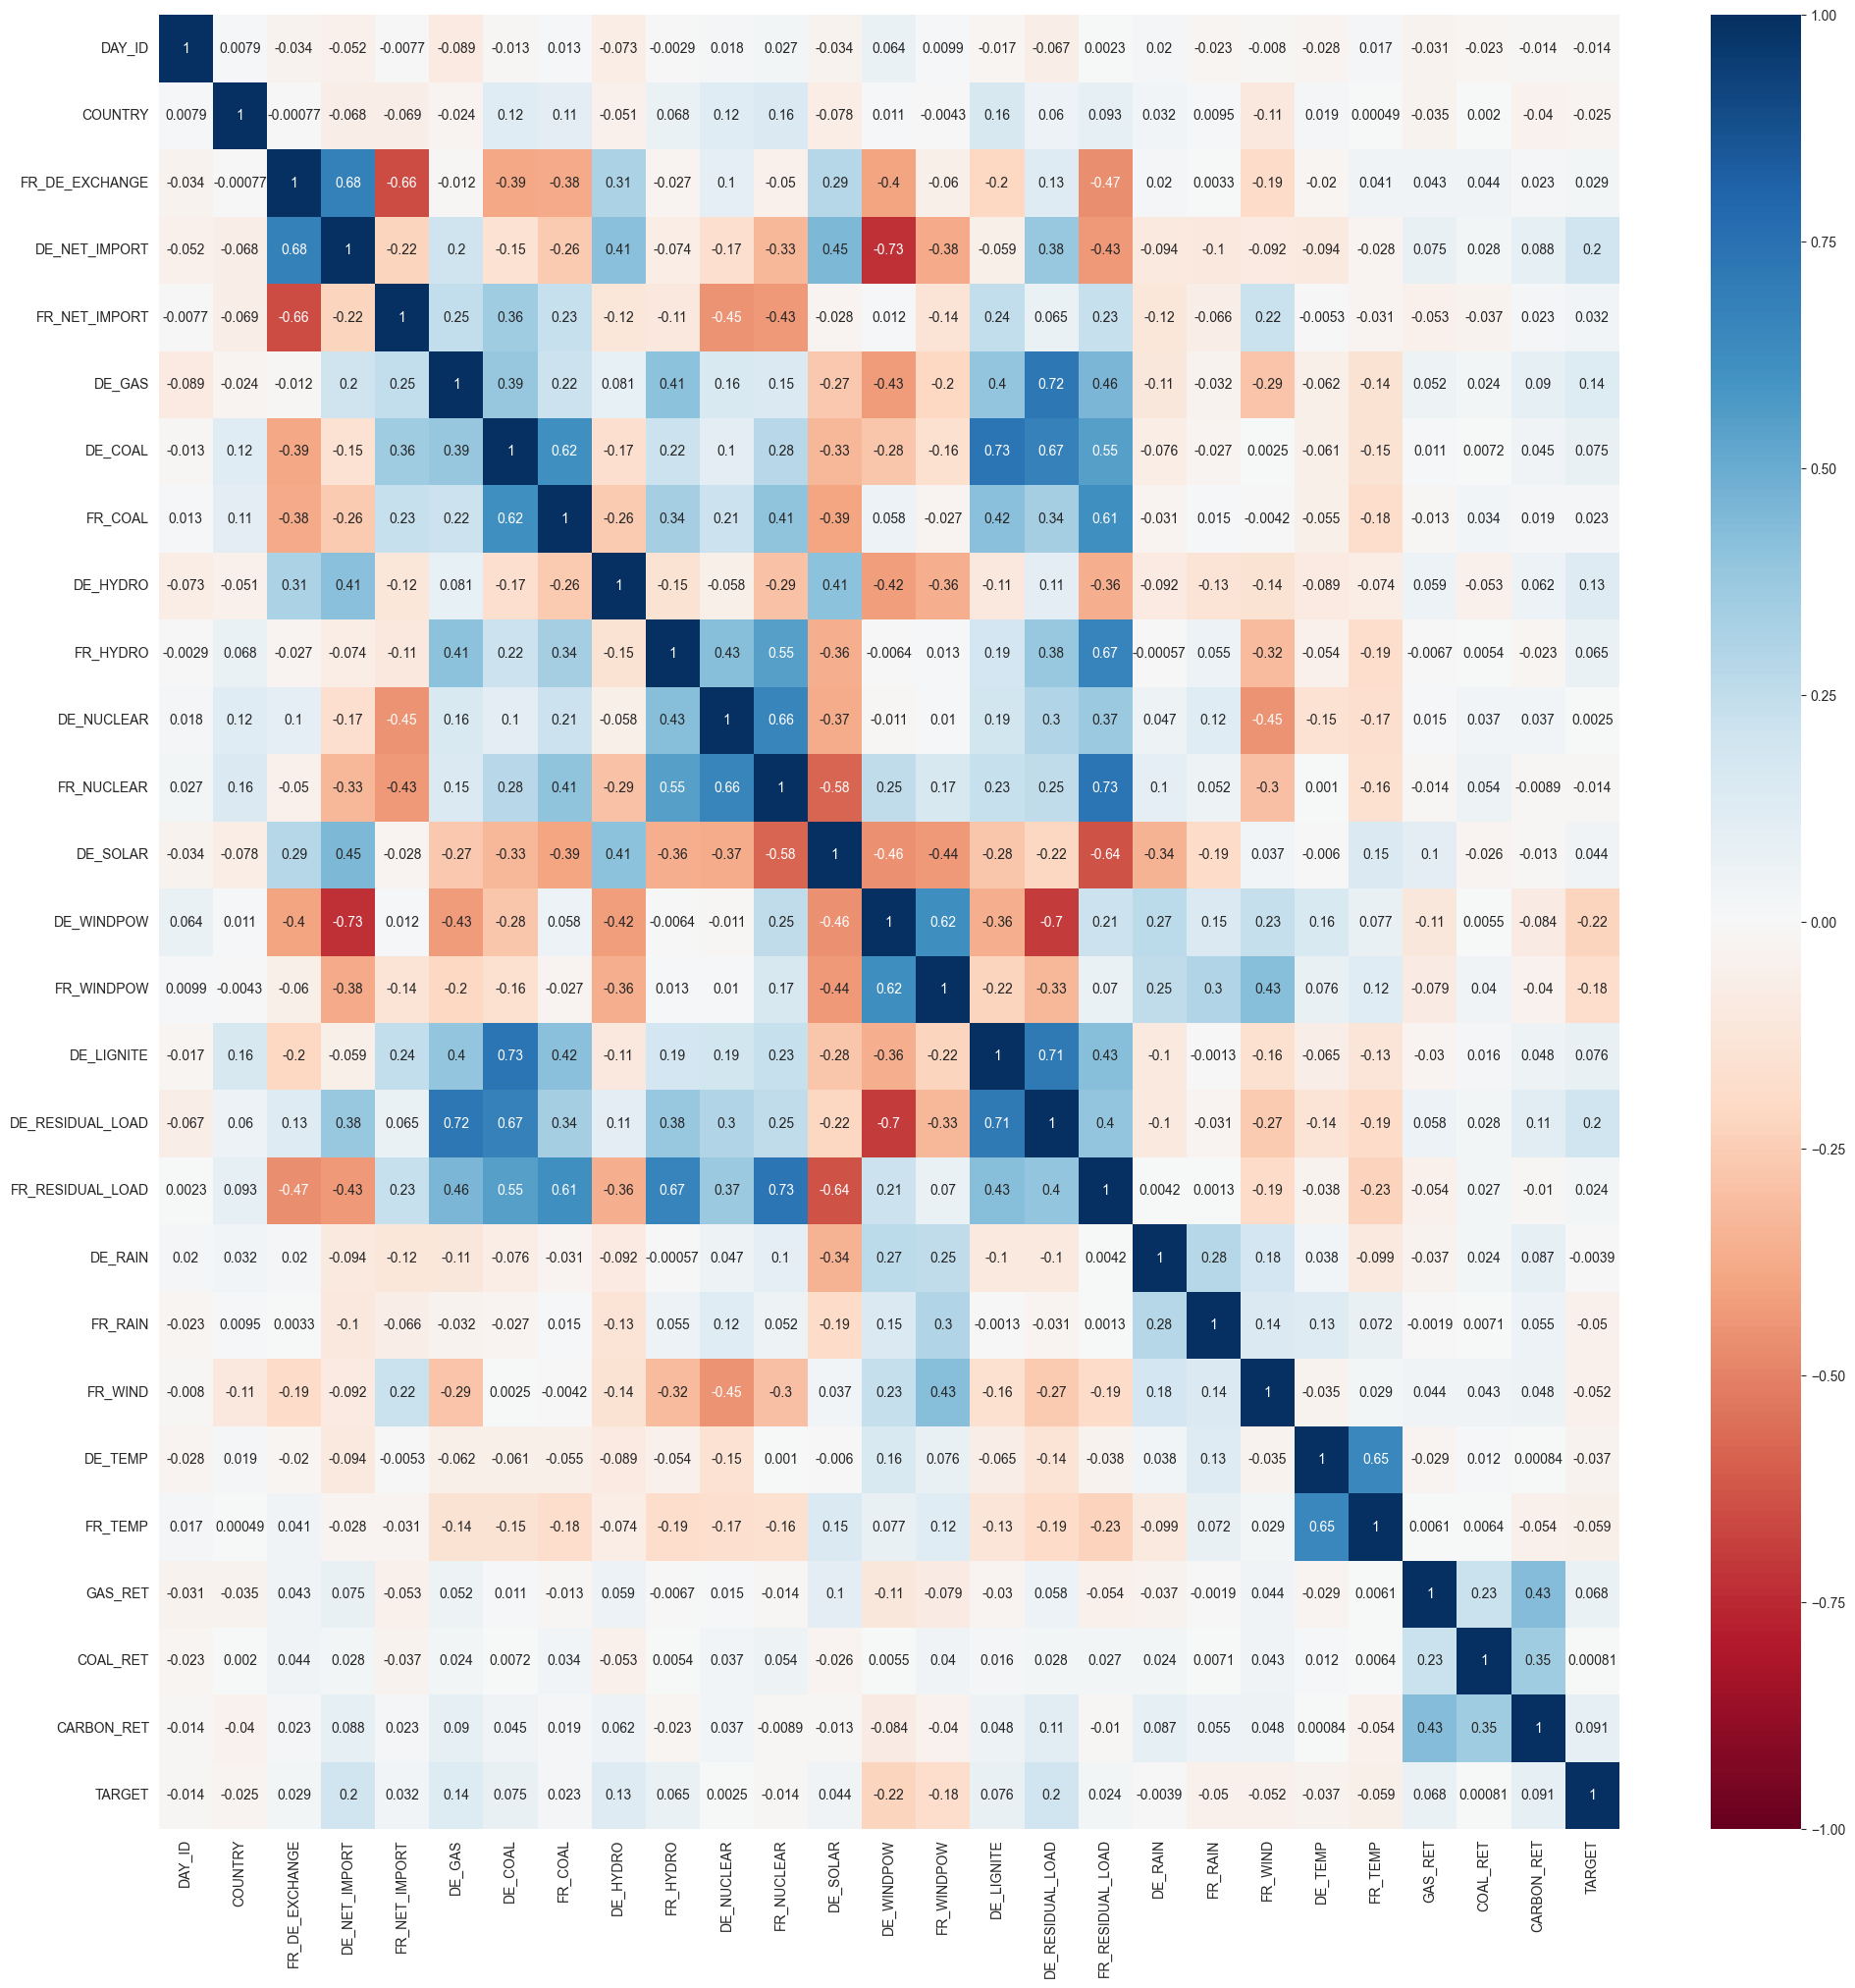

In [25]:
# PLot the heatmap

plt.figure(figsize=(24, 24))
sns.heatmap(train_set.corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)

<Axes: >

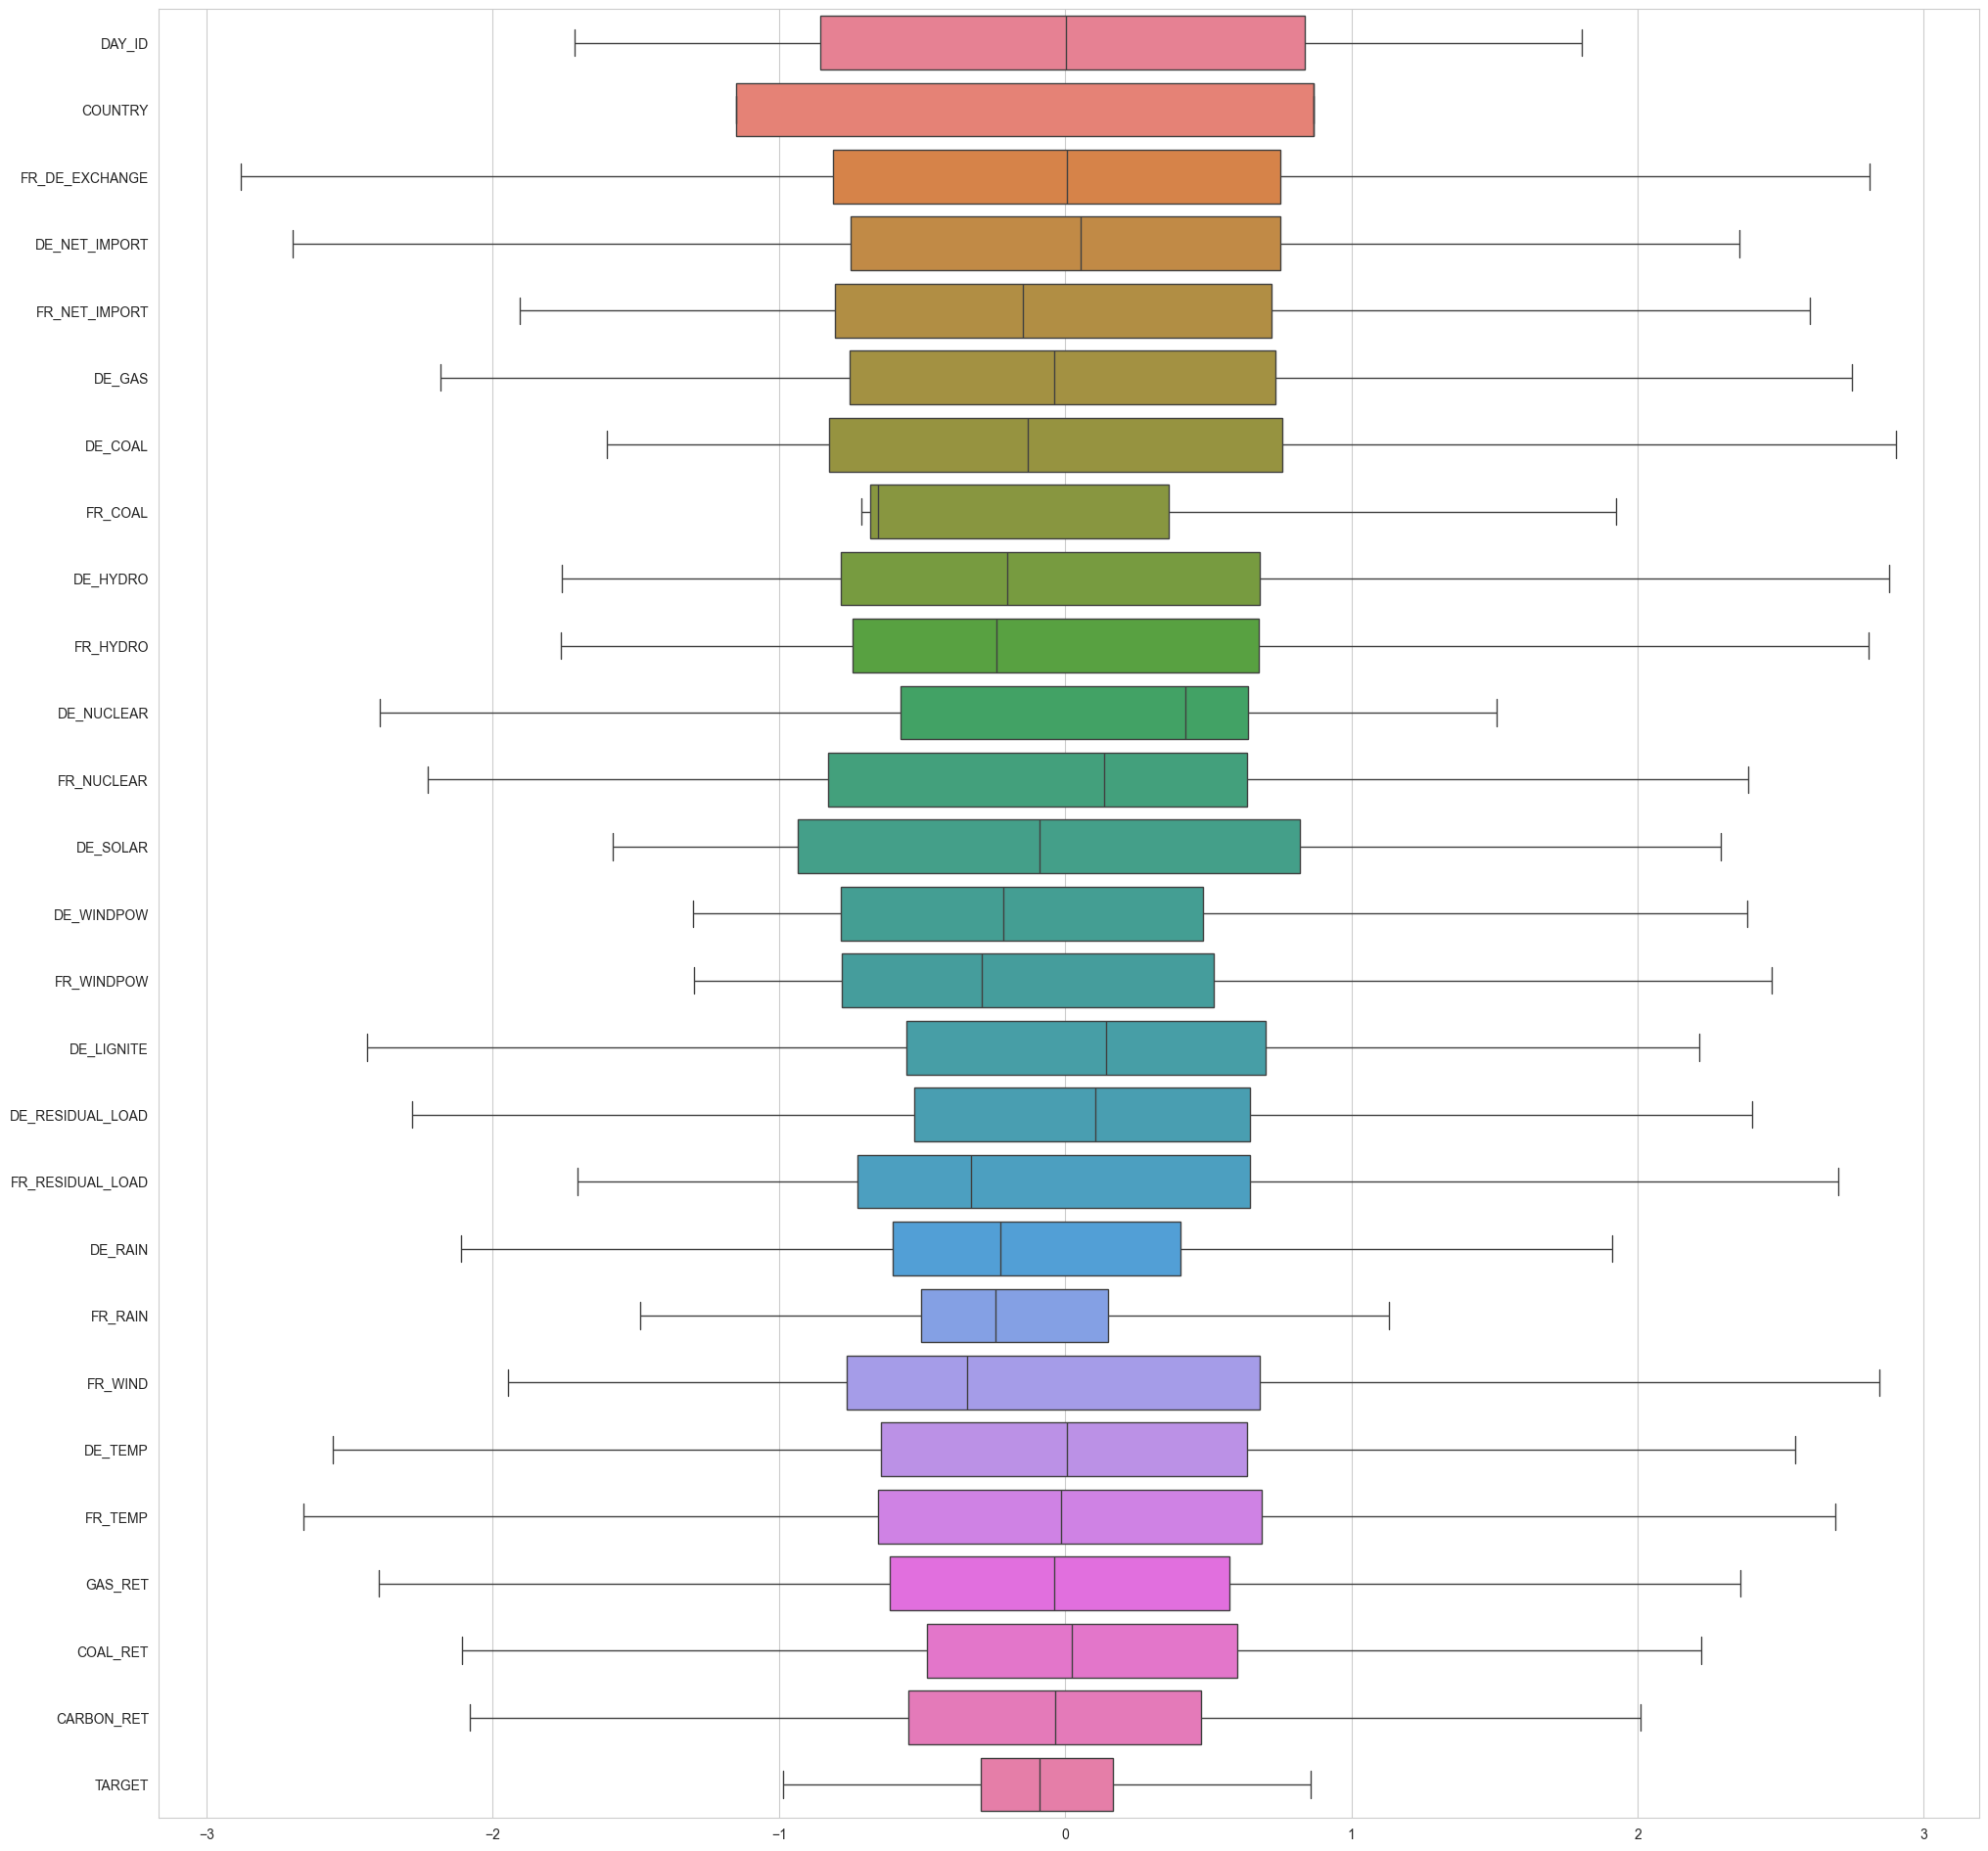

In [26]:
# Plot boxplot of each column in 1 figure of the train set: X_train and y_train

plt.figure(figsize=(24, 24))
sns.boxplot(data=train_set, orient='h')

## Data Analysis

In [27]:
# Fit a model and plot the evolution of the train and test scores with the hyperparameter

from sklearn.metrics import make_scorer

models = {}

def spearman_corr(y_true, y_pred, **kwargs):
    return stats.spearmanr(y_true, y_pred)[0]

def fit_and_vary_hyperparameters(regressor, param_grid, X, y):
    grid = GridSearchCV(
                        estimator=regressor, 
                        param_grid=param_grid,
                        cv=KFold(
                            n_splits=5, 
                            shuffle=True, 
                            random_state=int(perf_counter() * 100), 
                        ),  

                        # Spearman Correlation, R2 and RMSE
                        scoring={
                            'spearman_corr': make_scorer(spearman_corr, greater_is_better=True),
                            'r2': 'r2',
                            'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                        },
                        n_jobs=-1,
                        verbose=1,
                        return_train_score=True,
                        refit='neg_root_mean_squared_error'
                        )
    
    grid.fit(X, y)
    
    # Print best score,best r2 score, best parameters and spearman correlation with target column

    print(tabulate([[
        -grid.best_score_, 
        grid.cv_results_['mean_test_r2'][grid.best_index_],
        grid.best_params_,
        grid.cv_results_['mean_test_spearman_corr'][grid.best_index_]
        ]], 
        headers=['RMSE', 
                'Best r2 score',
                'Best parameters',
                'Spearman correlation'
                ],
        tablefmt='orgtbl')
    )
    
    # Plot the evolution of the train and test scores with the hyperparameter for each metric with the best parameters
   
    data = pd.DataFrame(grid.cv_results_)
    for param in param_grid:
        data_to_plot = data.copy()

        # Go through each hyperparameter and delete all the line where the other parameter are not the best

        for other_param in param_grid:
            if other_param != param:
                data_to_plot = data_to_plot[data_to_plot['param_' + other_param] == grid.best_params_[other_param]]

        # Check if the hyperparameter is a list of numbers or a list of strings
        if type(param_grid[param][0]) == int or type(param_grid[param][0]) == float or type(param_grid[param][0]) == np.float64:
            param_to_plot = param_grid[param]
        else:
            param_to_plot = [str(i) for i in param_grid[param]]
        

        fig, ax1 = plt.subplots(figsize=(12, 4))
        plt.xlabel(param)

        ax1.plot(param_to_plot, -data_to_plot['mean_train_neg_root_mean_squared_error'], label='RMSE Train', color='blue')
        ax1.plot(param_to_plot, -data_to_plot['mean_test_neg_root_mean_squared_error'], label='RMSE Test', color='green')
        ax1.set_ylabel('RMSE', color='blue')
        ax1.legend(loc=1)

        ax2 = ax1.twinx()
        ax2.plot(param_to_plot, data_to_plot['mean_train_spearman_corr'], label='Spearman Corr Train', linestyle='--', color='orange')
        ax2.plot(param_to_plot, data_to_plot['mean_test_spearman_corr'], label='Spearman Corr Test', color='red', linestyle='--')
        ax2.set_ylabel('Spearman Corr', color='red')
        ax2.legend(loc=2)

        fig.tight_layout()
        
        plt.show()

    return grid
    

### Linear Regression

Fitting 5 folds for each of 2 candidates, totalling 10 fits
|     RMSE |   Best r2 score | Best parameters          |   Spearman correlation |
|----------+-----------------+--------------------------+------------------------|
| 0.995611 |        0.002702 | {'fit_intercept': False} |               0.214576 |


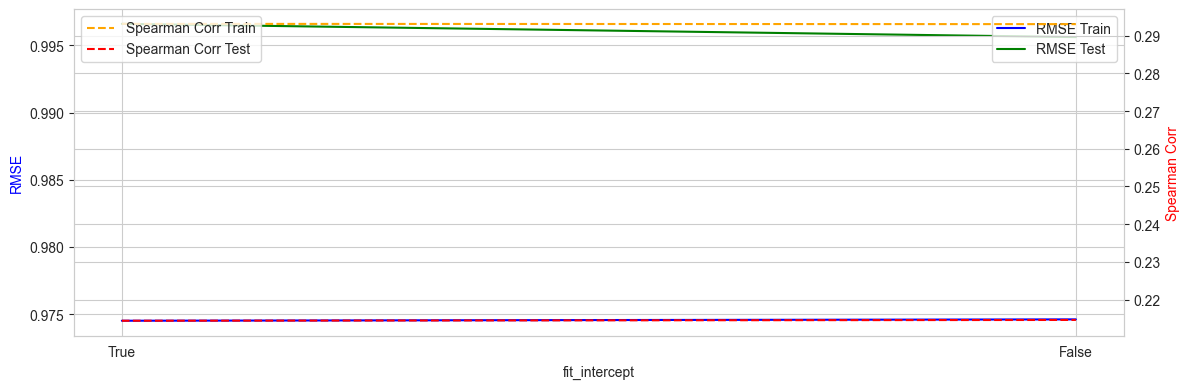

<BarContainer object of 26 artists>

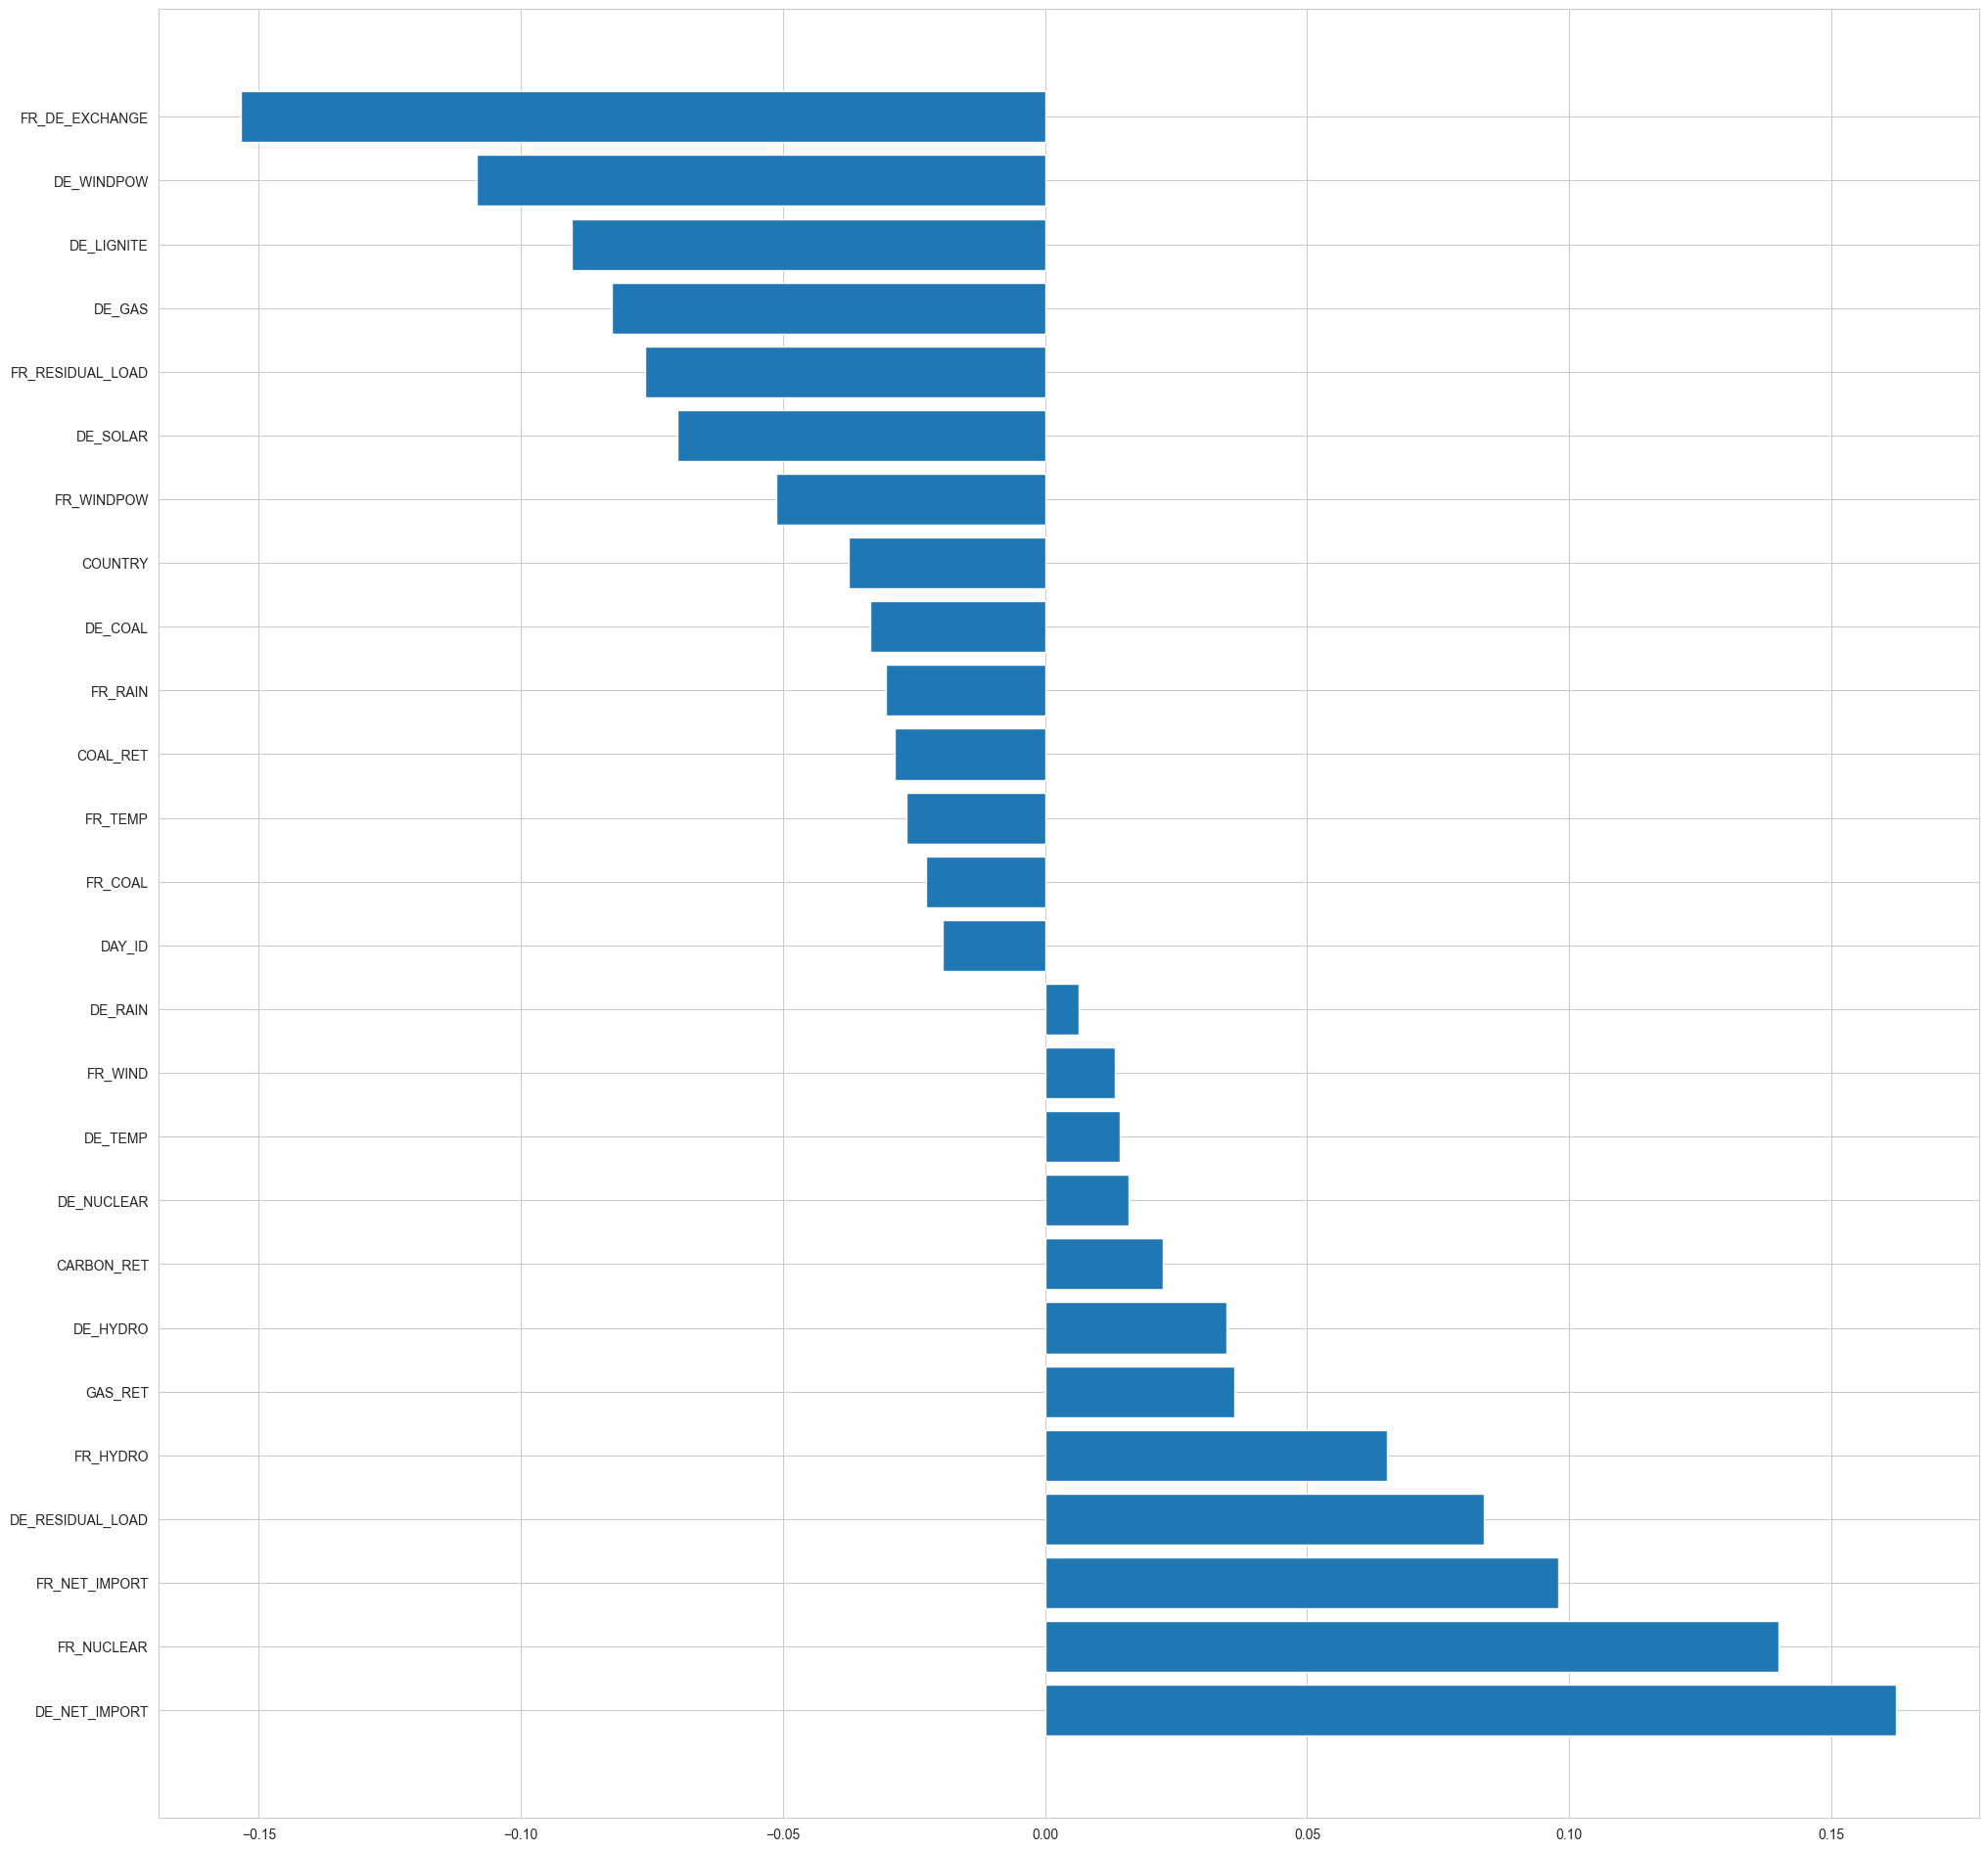

In [28]:
# Linear regression
hyperparameters = {
  'fit_intercept': [True, False]
}

models["linear_regression"]= fit_and_vary_hyperparameters(LinearRegression(), hyperparameters, X_train, y_train)

# Plot coef of linear regression by decreasing order

plt.figure(figsize=(24, 24))

coefficient = models["linear_regression"].best_estimator_.coef_
plt.barh(X_train.columns[np.argsort(-coefficient)], coefficient[np.argsort(-coefficient)])

### Regularized Linear Regression

Fitting 5 folds for each of 50 candidates, totalling 250 fits
|     RMSE |   Best r2 score | Best parameters                          |   Spearman correlation |
|----------+-----------------+------------------------------------------+------------------------|
| 0.987598 |       0.0252714 | {'alpha': np.float64(372.7593720314942)} |               0.243895 |


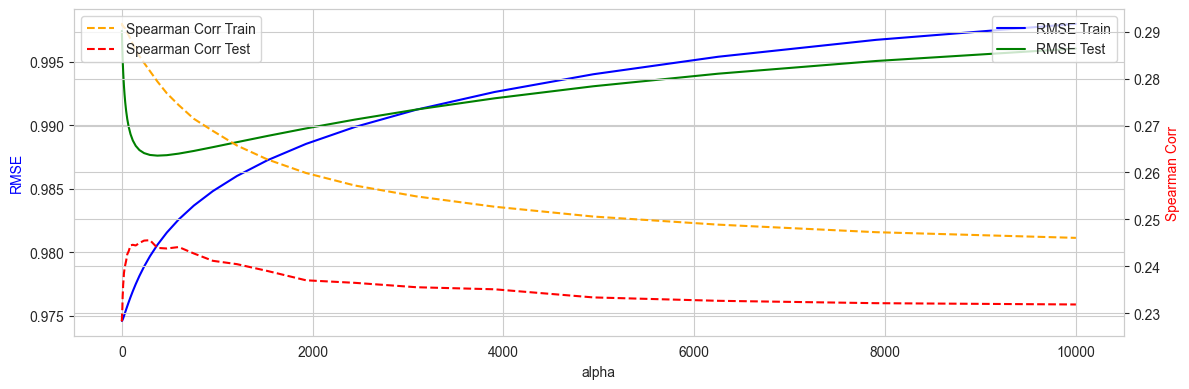

In [29]:
# Ridge Regression
hyperparameters = {
    'alpha': np.logspace(-1, 4),
}

models["ridge"] = fit_and_vary_hyperparameters(Ridge(), hyperparameters, X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
|     RMSE |   Best r2 score | Best parameters                             |   Spearman correlation |
|----------+-----------------+---------------------------------------------+------------------------|
| 0.986403 |       0.0115852 | {'alpha': np.float64(0.021209508879201904)} |               0.224433 |


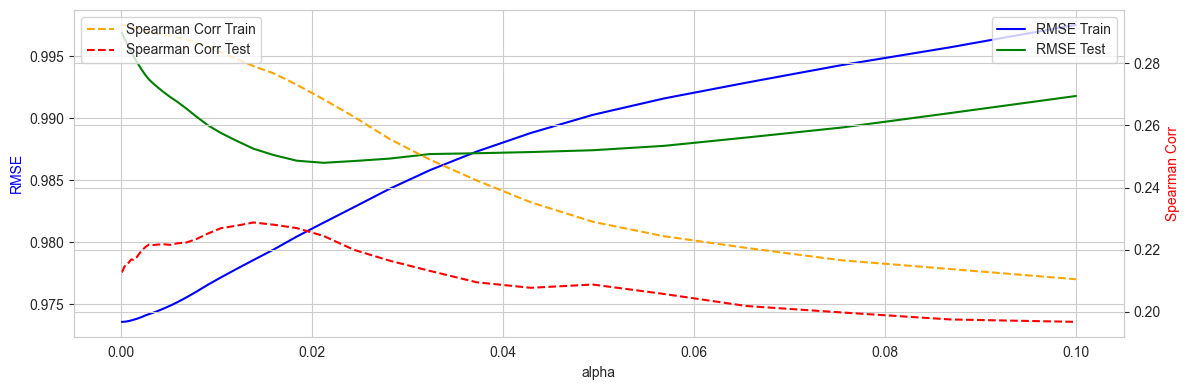

<BarContainer object of 26 artists>

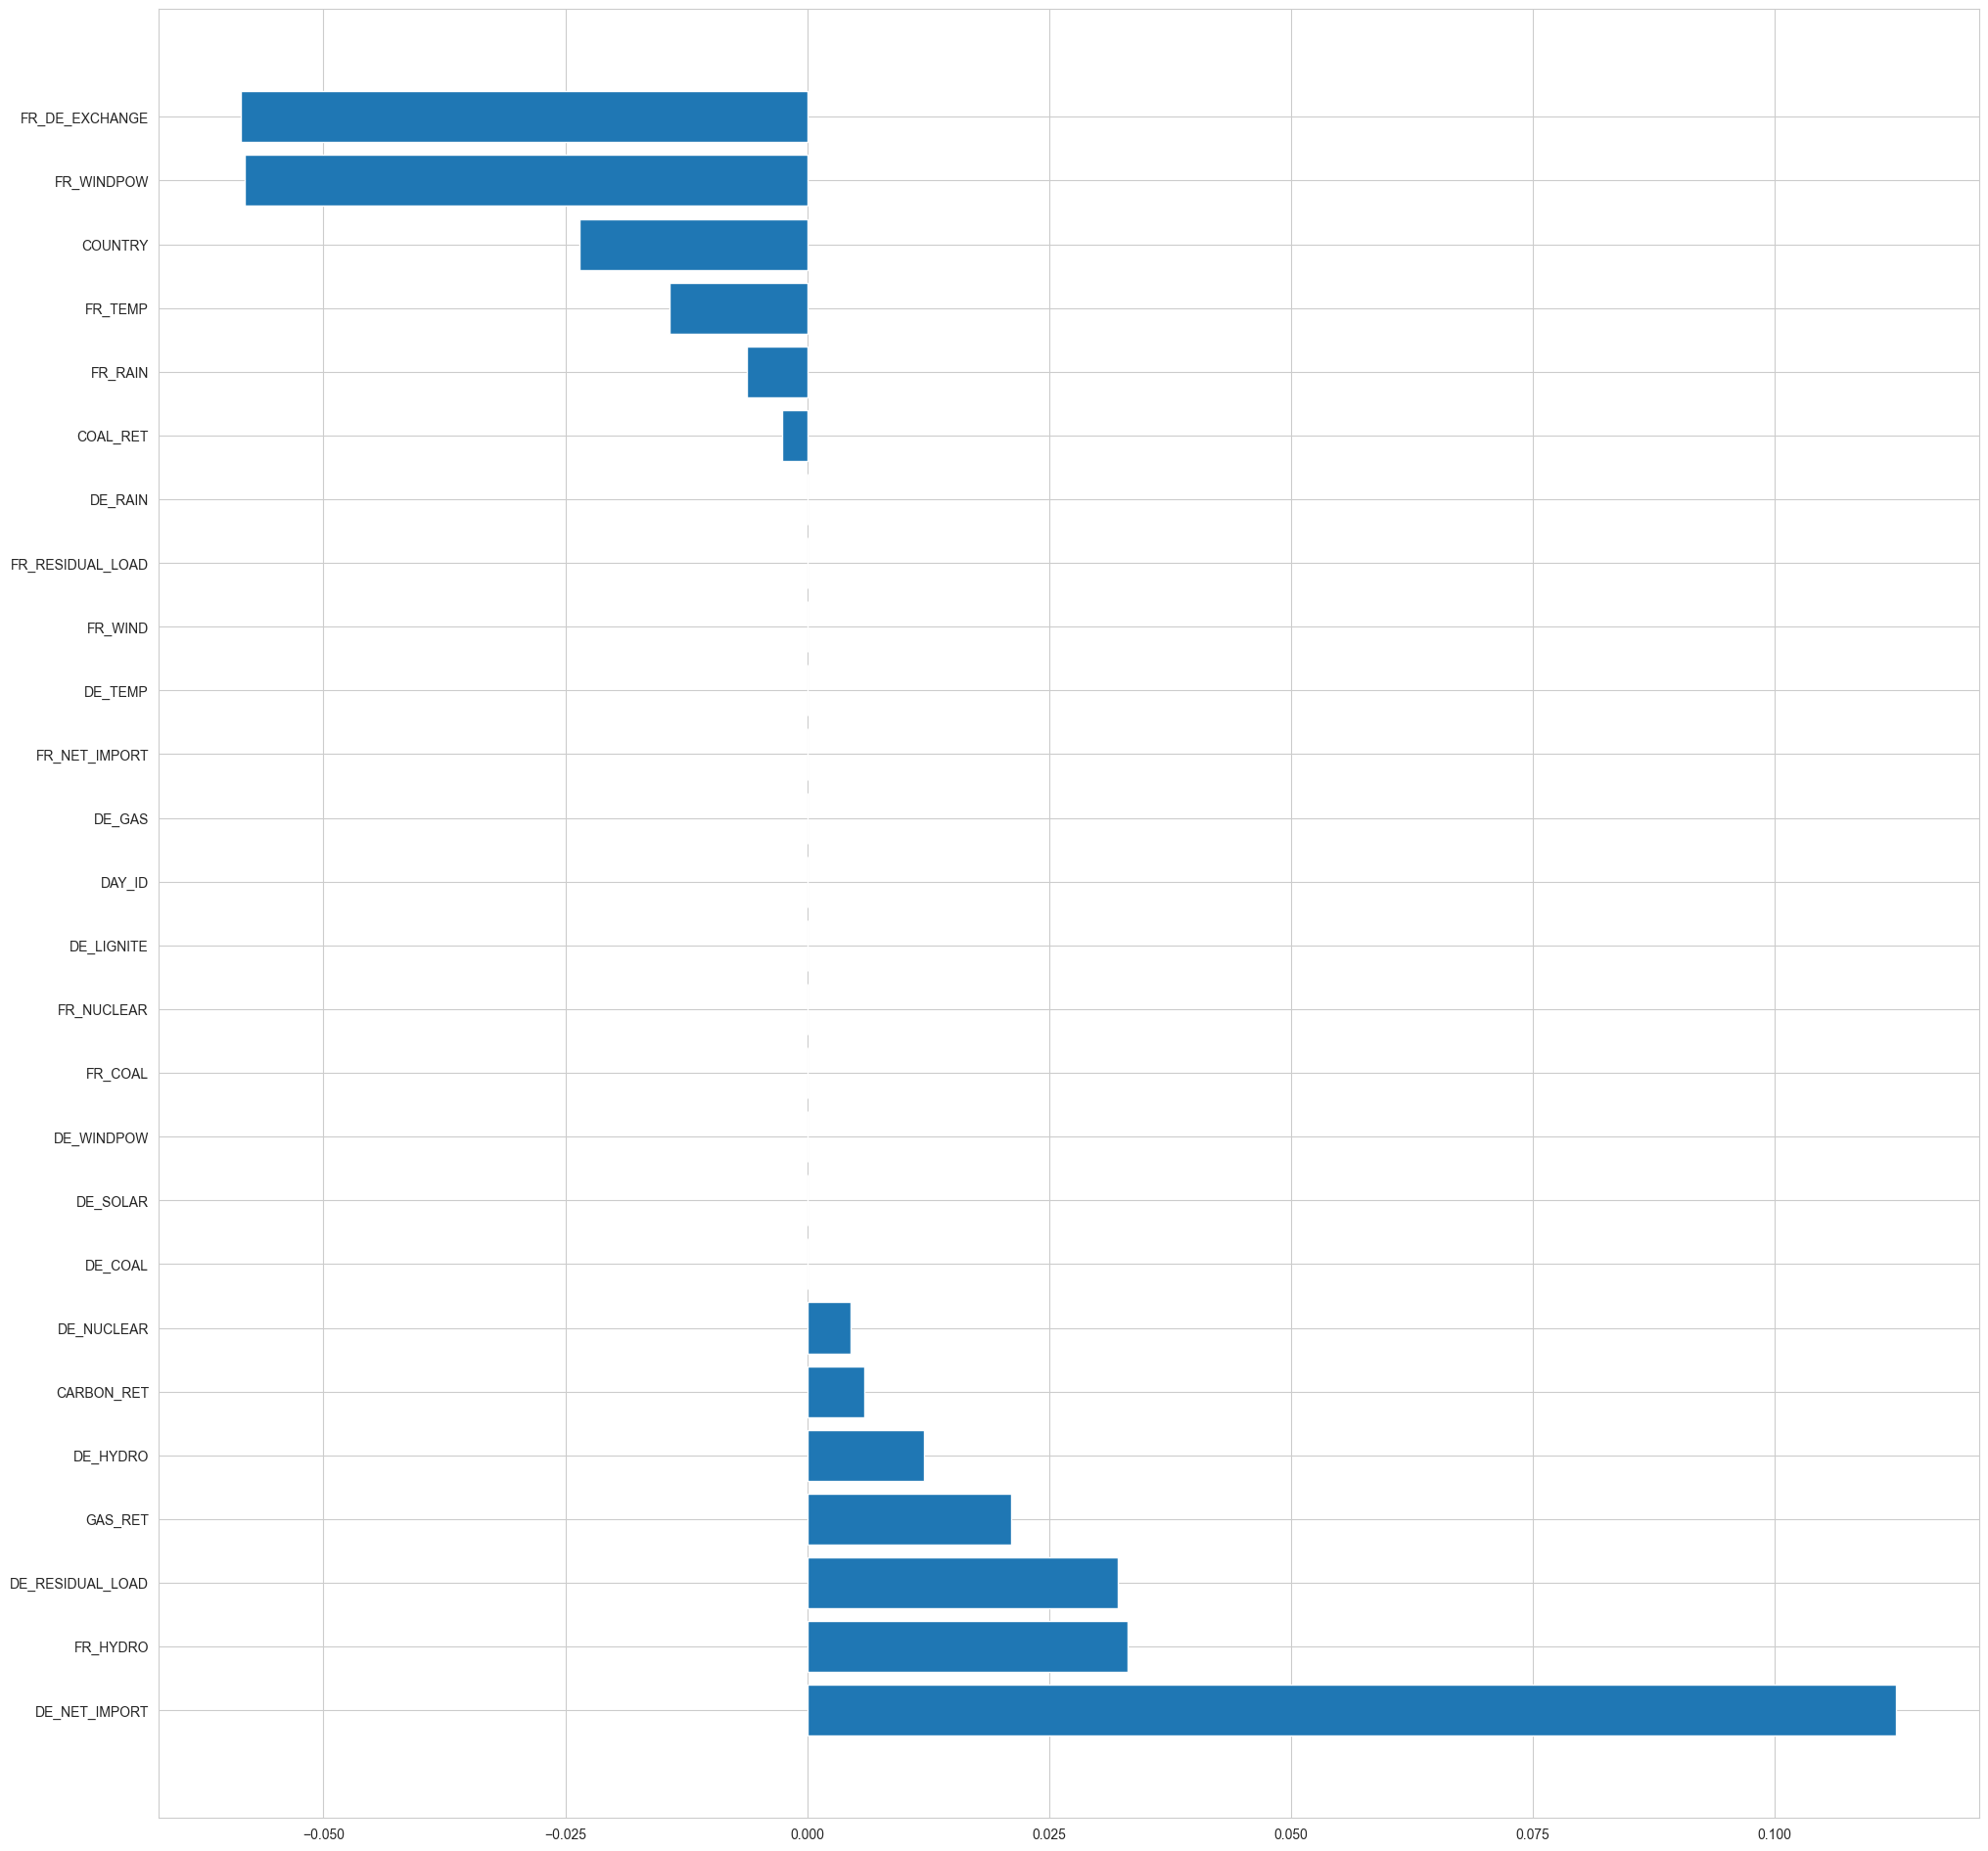

In [30]:
# Lasso Regression
hyperparameters = {
    'alpha': np.logspace(-4, -1),
}

models["lasso"] = fit_and_vary_hyperparameters(Lasso(max_iter=50000), hyperparameters, X_train, y_train)

# Plot coef of lasso regression by decreasing order

plt.figure(figsize=(24, 24))
plt.barh(X_train.columns[np.argsort(-models["lasso"].best_estimator_.coef_)], models["lasso"].best_estimator_.coef_[np.argsort(-models["lasso"].best_estimator_.coef_)])

### K-Nearest Neighbors

Fitting 5 folds for each of 98 candidates, totalling 490 fits
|    RMSE |   Best r2 score | Best parameters     |   Spearman correlation |
|---------+-----------------+---------------------+------------------------|
| 0.98854 |       0.0225288 | {'n_neighbors': 85} |               0.189362 |


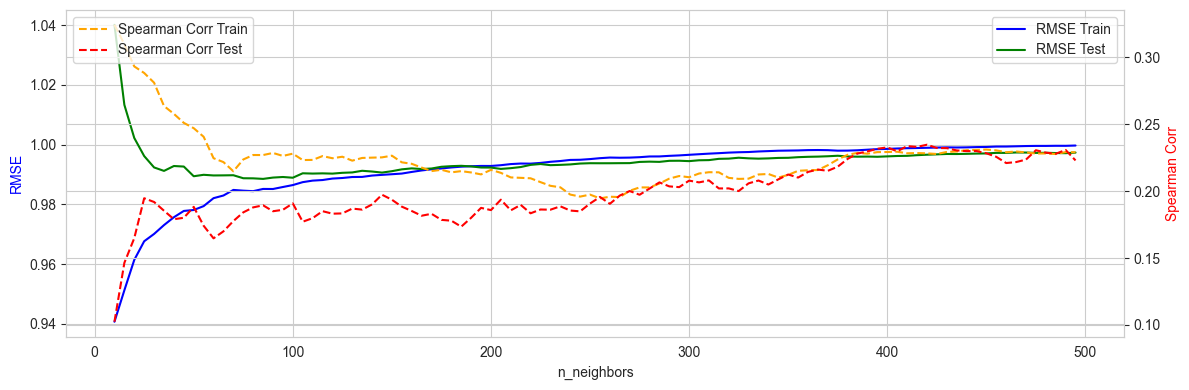

In [31]:
# KNN Regression
hyperparameters = {
    'n_neighbors': range(10, 500, 5),
}

models["knn"] = fit_and_vary_hyperparameters(KNeighborsRegressor(), hyperparameters, X_train, y_train)


### Decision Tree

Fitting 5 folds for each of 19 candidates, totalling 95 fits
|    RMSE |   Best r2 score | Best parameters   |   Spearman correlation |
|---------+-----------------+-------------------+------------------------|
| 1.00302 |     -0.00993613 | {'max_depth': 1}  |               0.115376 |


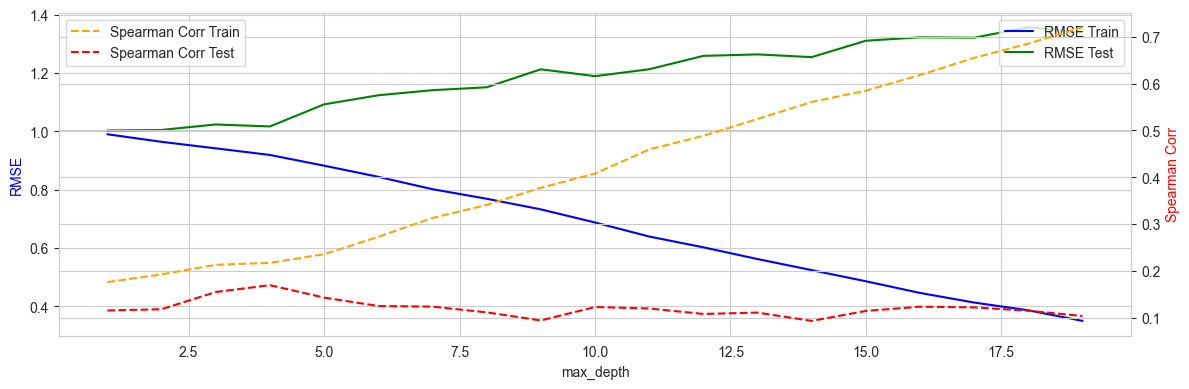

<BarContainer object of 26 artists>

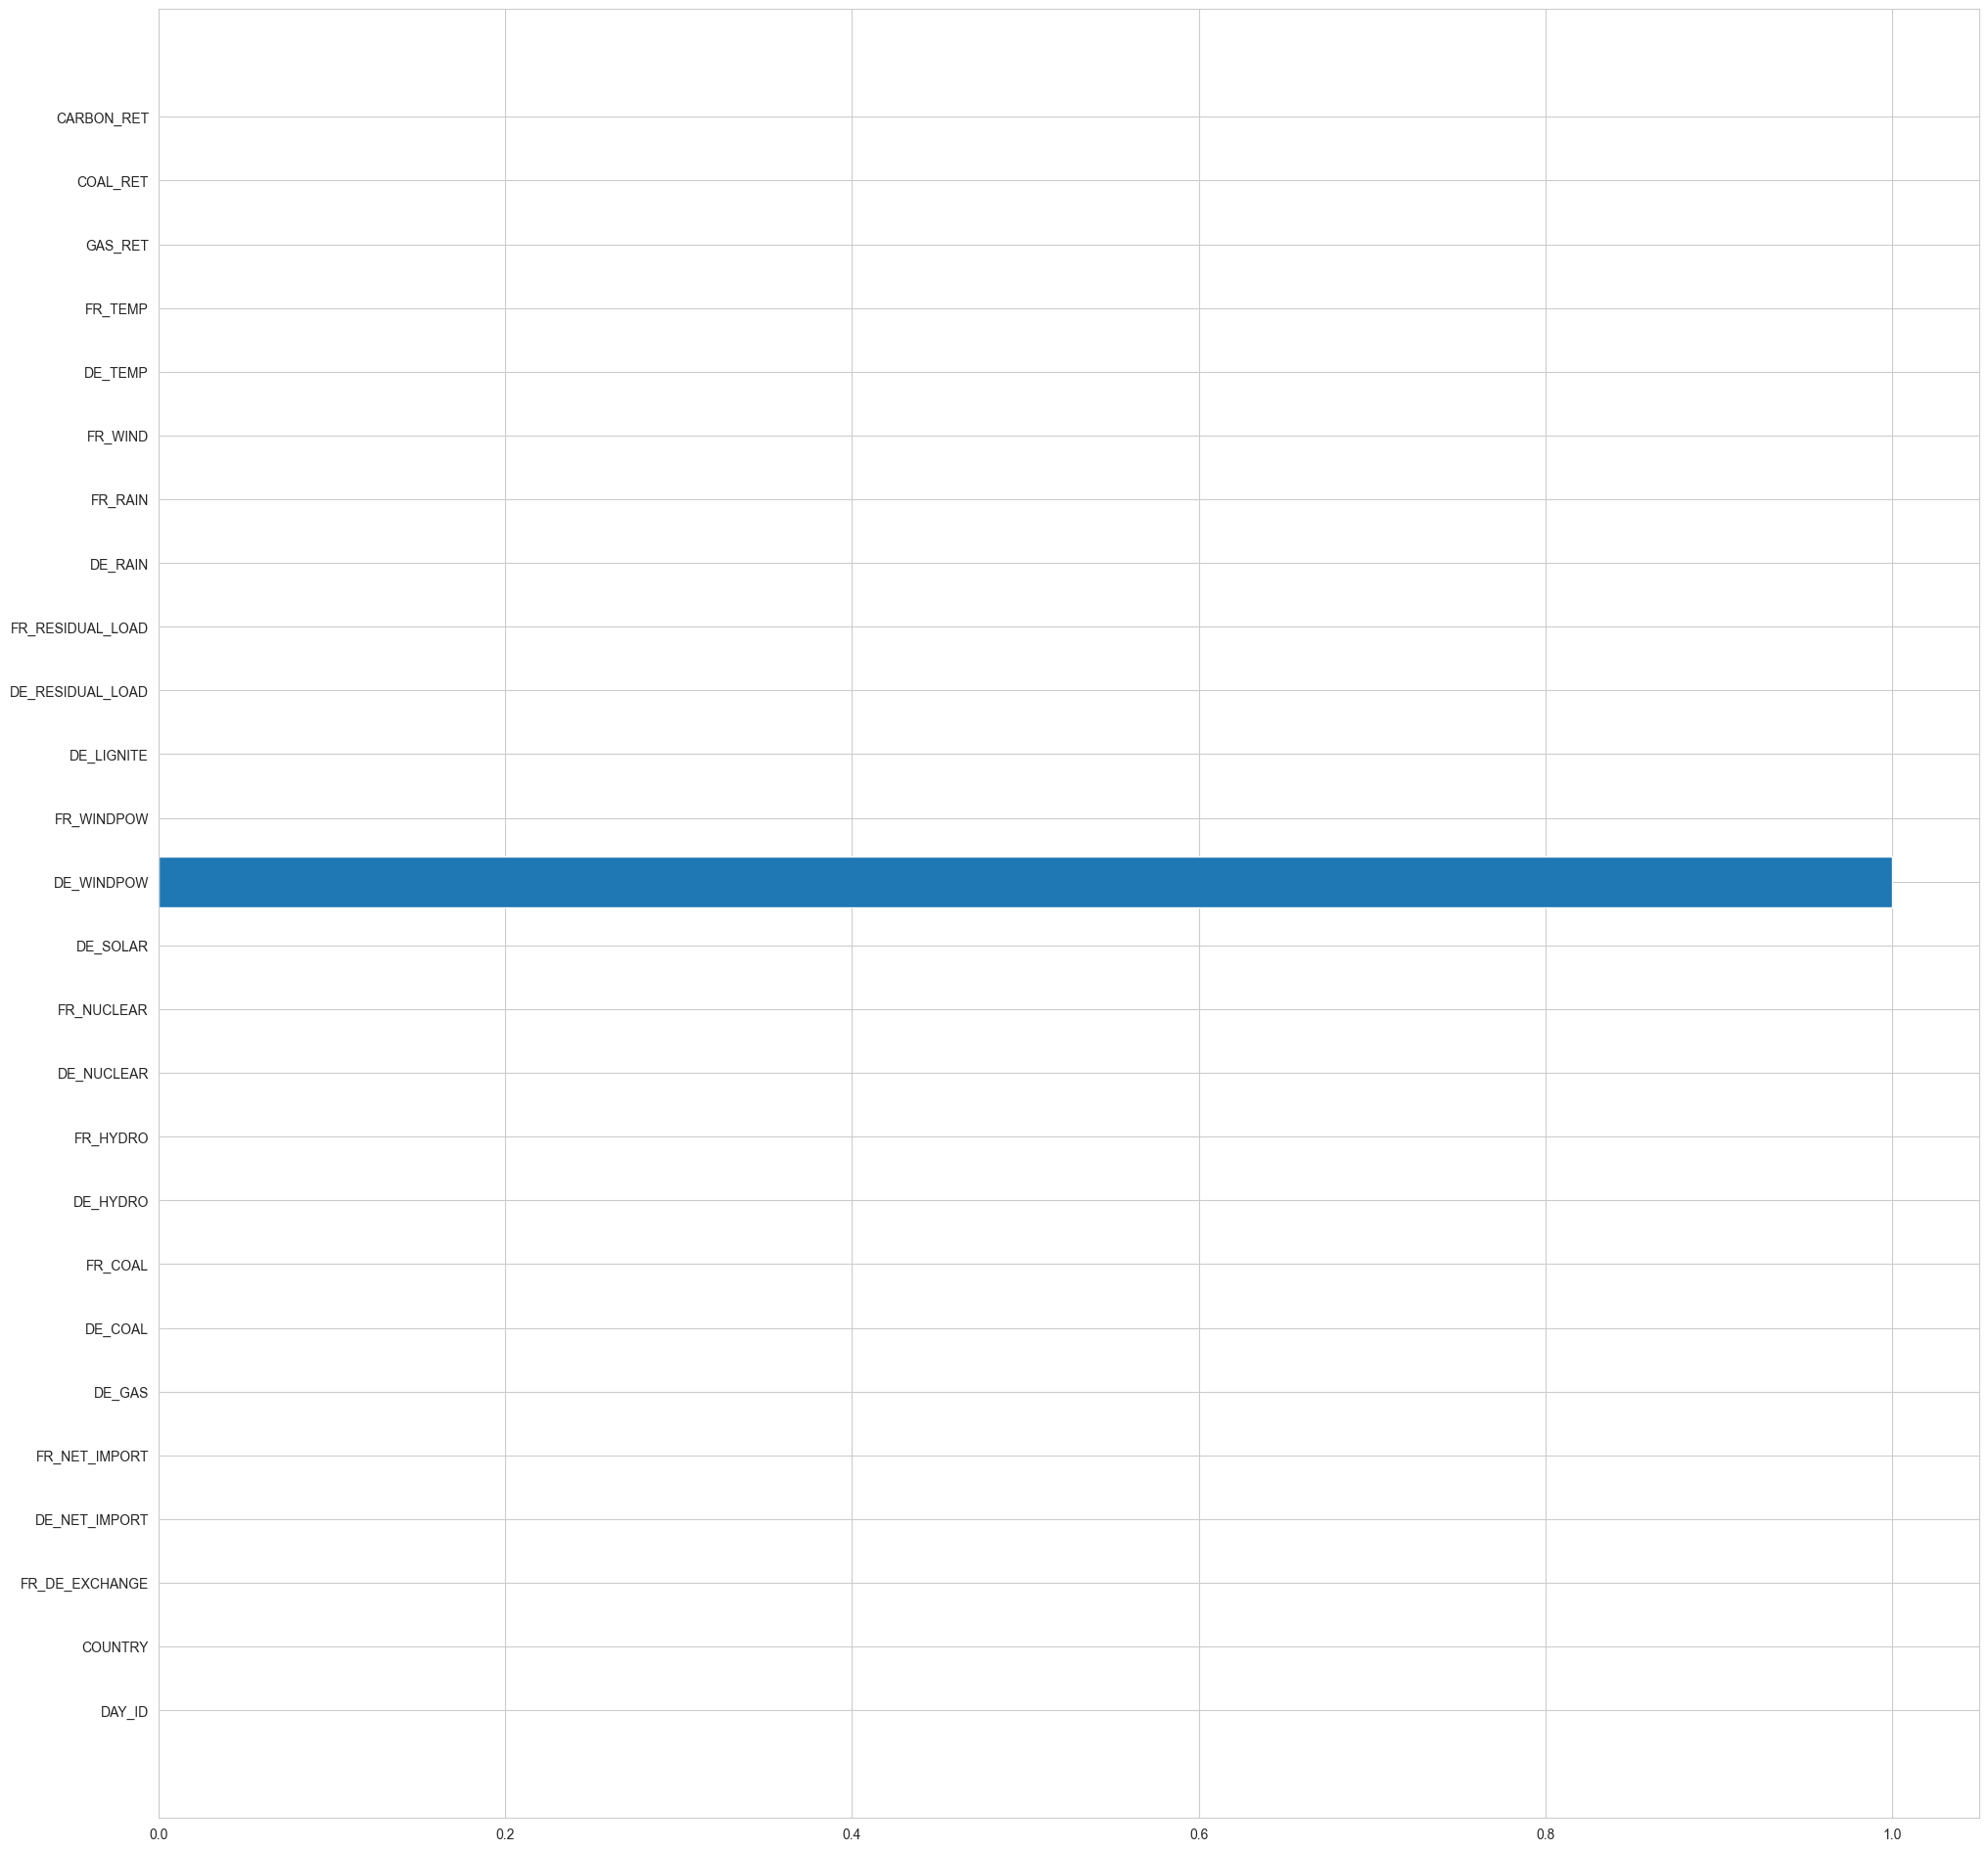

In [32]:
# Decision Tree Regression with different depth

hyperparameters = {
    'max_depth': range(1, 20, 1),
}

models["decision_tree"] = fit_and_vary_hyperparameters(DecisionTreeRegressor(), hyperparameters, X_train, y_train)

# Feature importance of the decision tree

plt.figure(figsize=(24, 24))
plt.barh(X_train.columns, models["decision_tree"].best_estimator_.feature_importances_)

### Random Forest

Fitting 5 folds for each of 15 candidates, totalling 75 fits
|    RMSE |   Best r2 score | Best parameters                          |   Spearman correlation |
|---------+-----------------+------------------------------------------+------------------------|
| 1.00688 |      -0.0187733 | {'max_depth': 5, 'min_samples_split': 5} |               0.171224 |


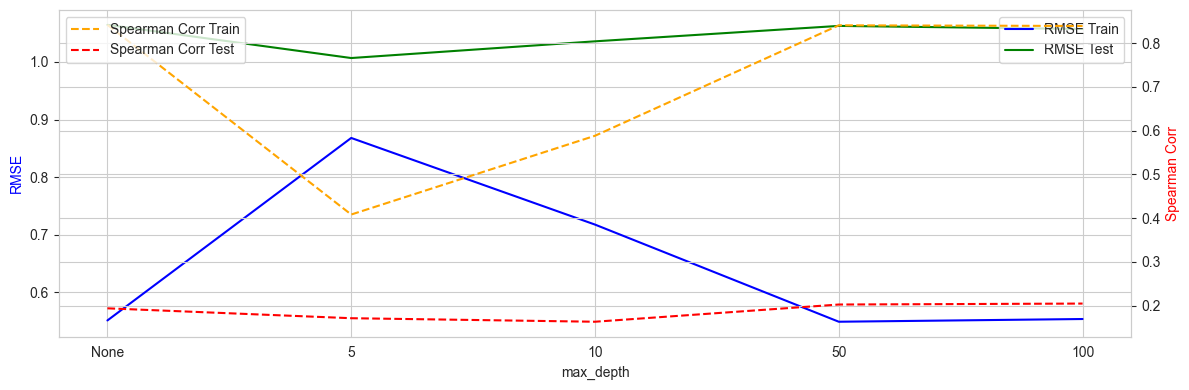

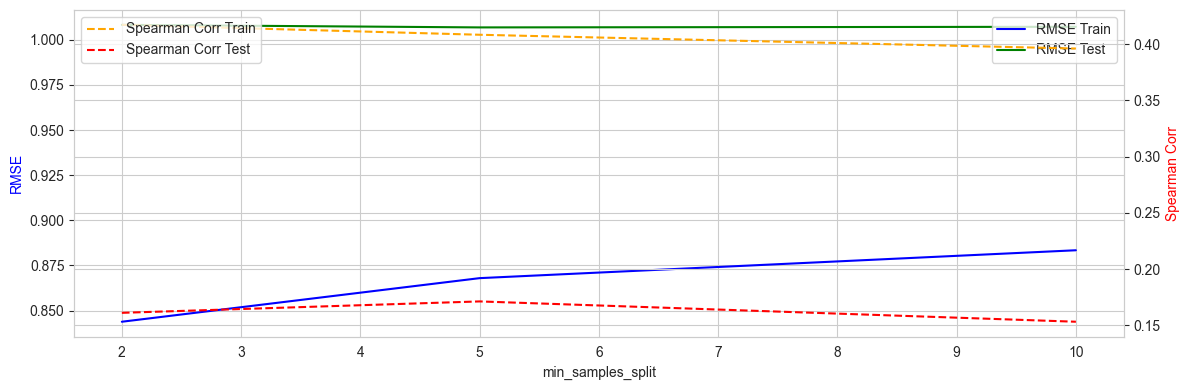

<BarContainer object of 26 artists>

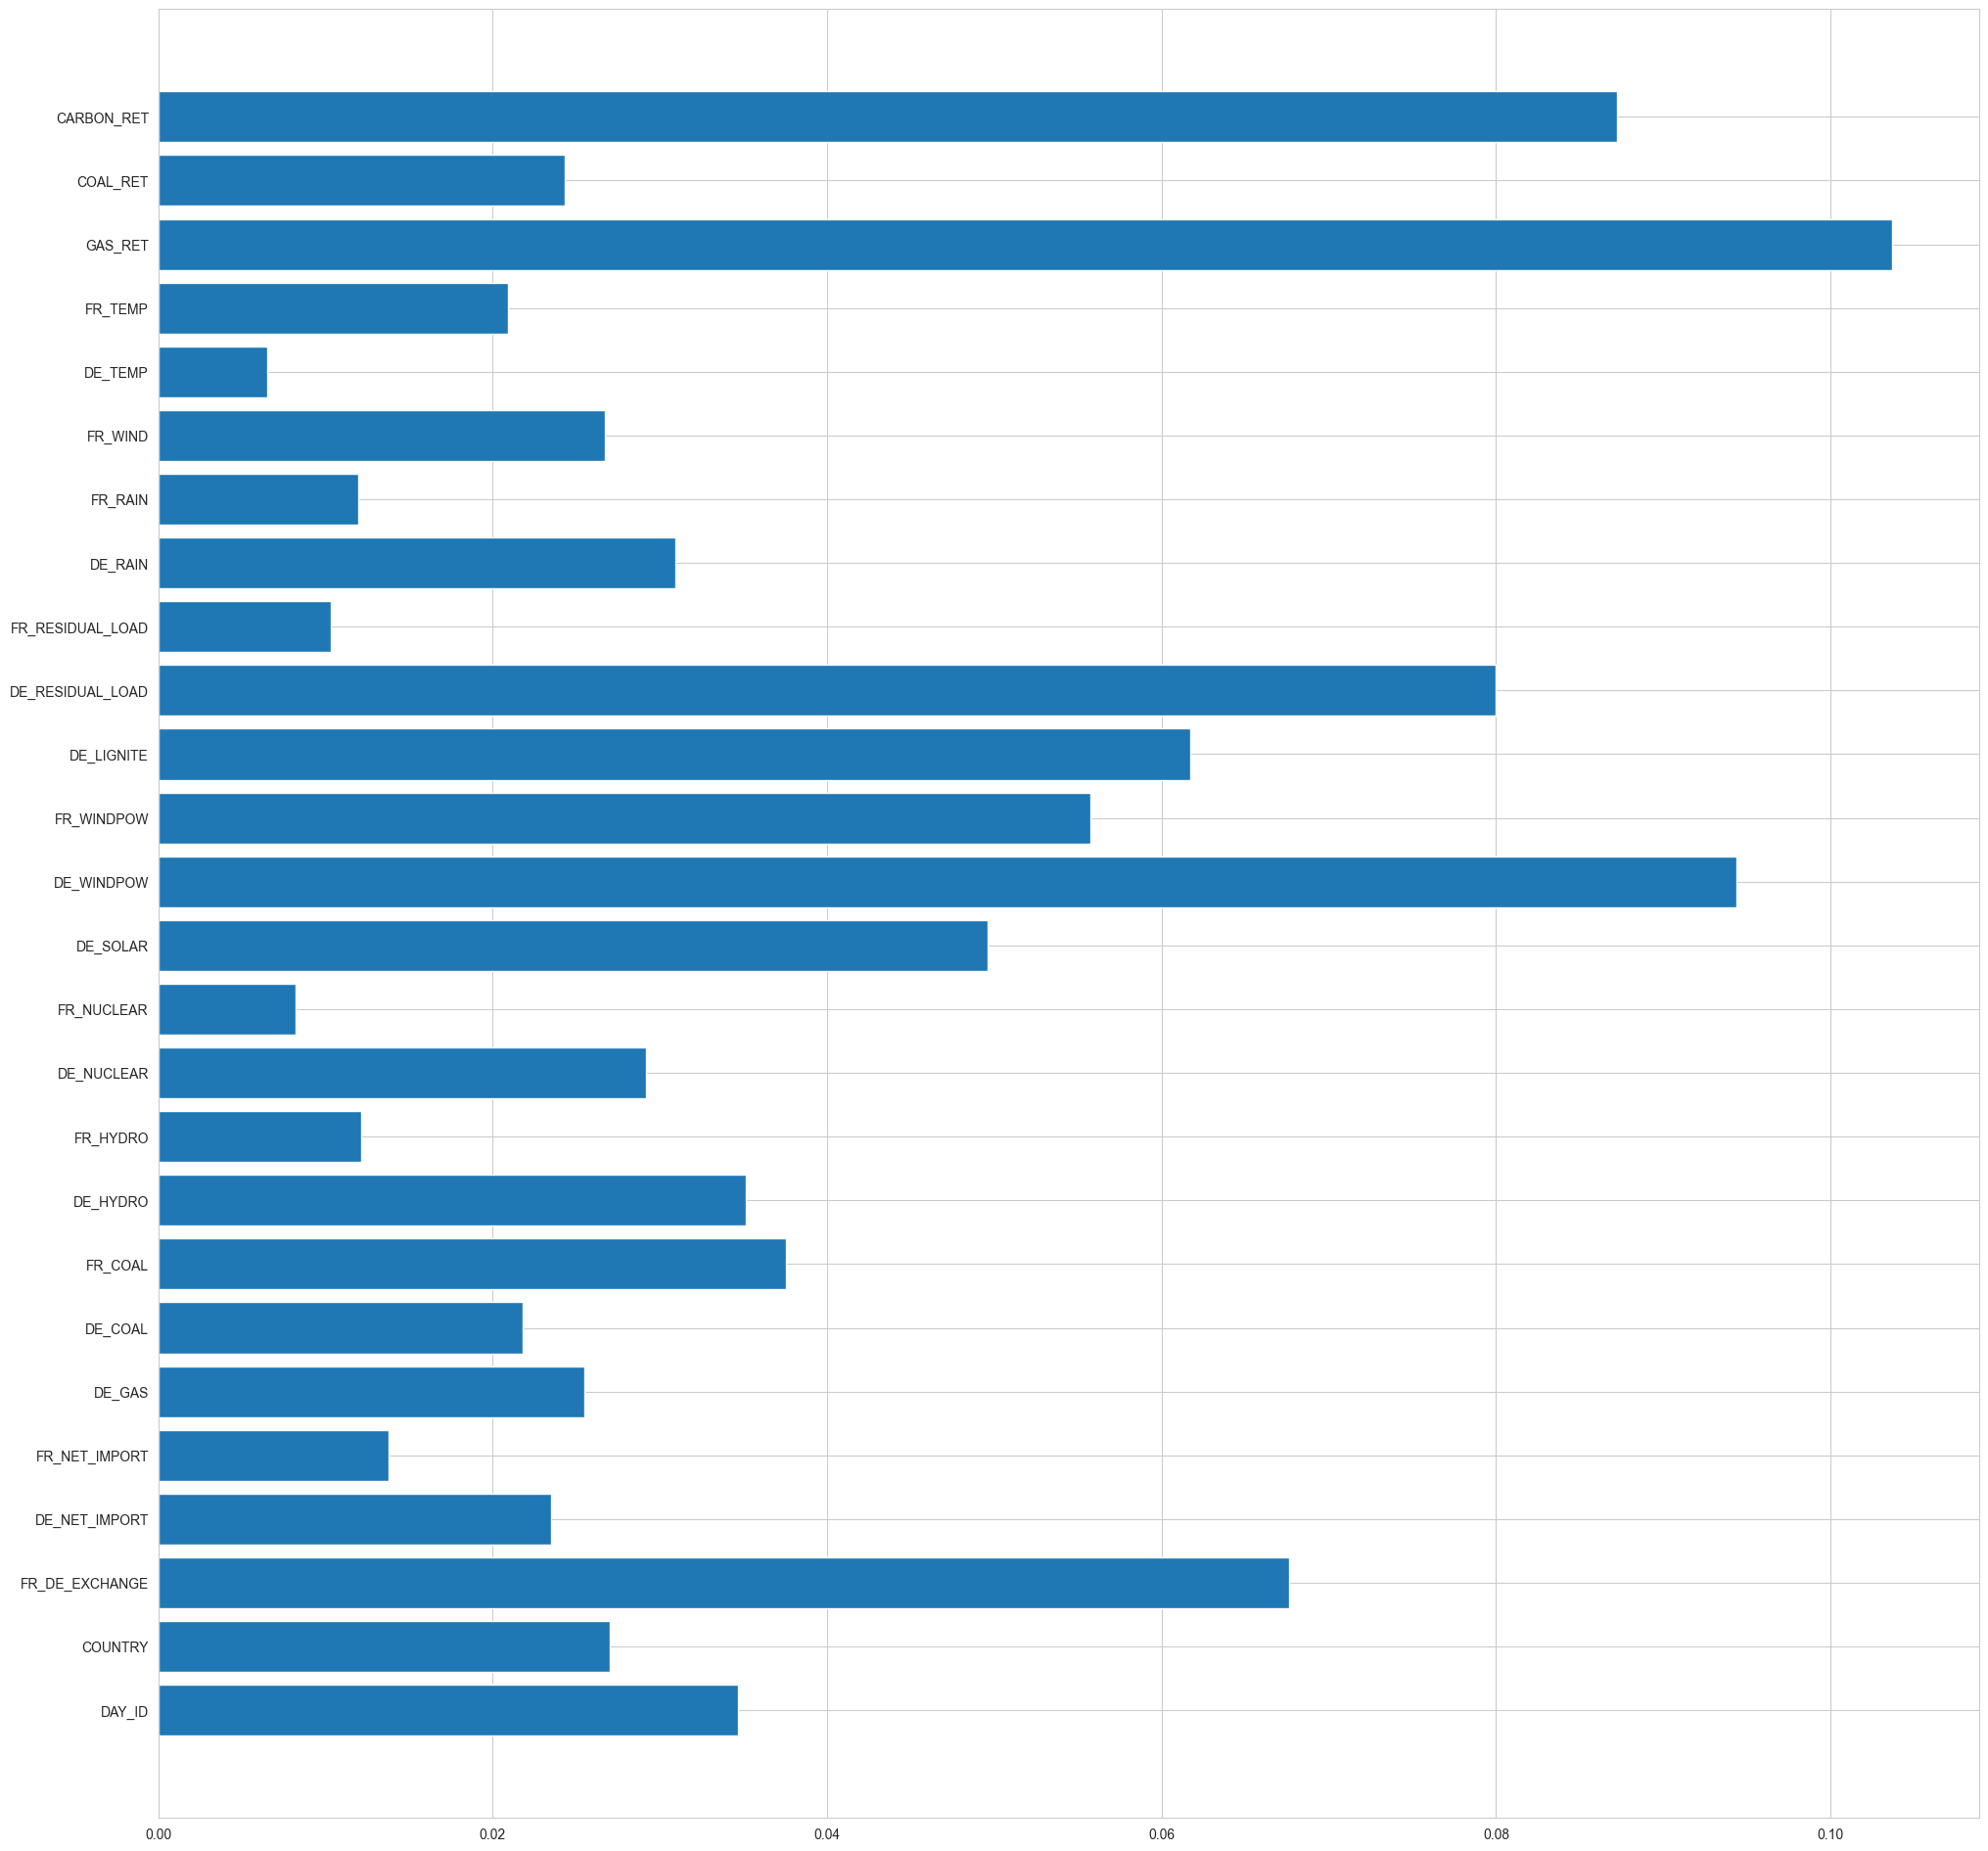

In [33]:
# Random Forest Regression

hyperparameters = {
    'max_depth': [None, 5, 10, 50, 100],
    'min_samples_split': [2, 5, 10],
}

models["random_forest"] = fit_and_vary_hyperparameters(RandomForestRegressor(), hyperparameters, X_train, y_train)

# Feature importance of the random forest horizontal barplot

plt.figure(figsize=(24, 24))
plt.barh(X_train.columns, models["random_forest"].best_estimator_.feature_importances_)

### Neural Network

Fitting 5 folds for each of 4 candidates, totalling 20 fits
|    RMSE |   Best r2 score | Best parameters                         |   Spearman correlation |
|---------+-----------------+-----------------------------------------+------------------------|
| 1.22158 |       -0.495665 | {'hidden_layer_sizes': (300, 300, 300)} |               0.136675 |


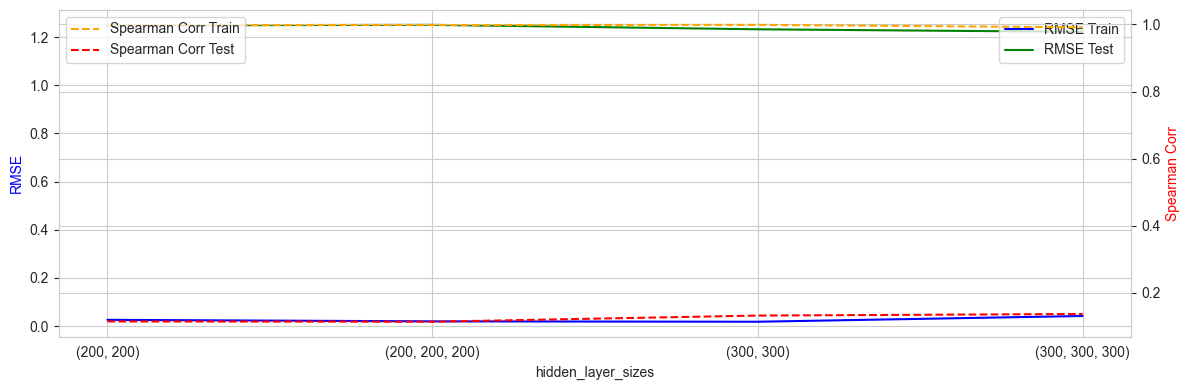

In [34]:
# Neural Network Regression with cross validation

hyperparameters = {
    'hidden_layer_sizes': [ 
        (200, 200), (200, 200, 200),
        (300, 300), (300, 300, 300),
    ],
}

models['neural_network'] = fit_and_vary_hyperparameters(MLPRegressor(max_iter=5000), hyperparameters, X_train, y_train)


## Ranking of the models

/var/folders/kb/sh6xl4v90jn6mlvsm5cn4jmm0000gn/T/ipykernel_25690/1696516134.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(models.keys()), y=[mean_squared_error[model] for model in models], palette='Blues')
/var/folders/kb/sh6xl4v90jn6mlvsm5cn4jmm0000gn/T/ipykernel_25690/1696516134.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(models.keys()), y=[r2[model] for model in models], palette='Blues')
/var/folders/kb/sh6xl4v90jn6mlvsm5cn4jmm0000gn/T/ipykernel_25690/1696516134.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.ba

Text(0, 0.5, 'spearman_corr')

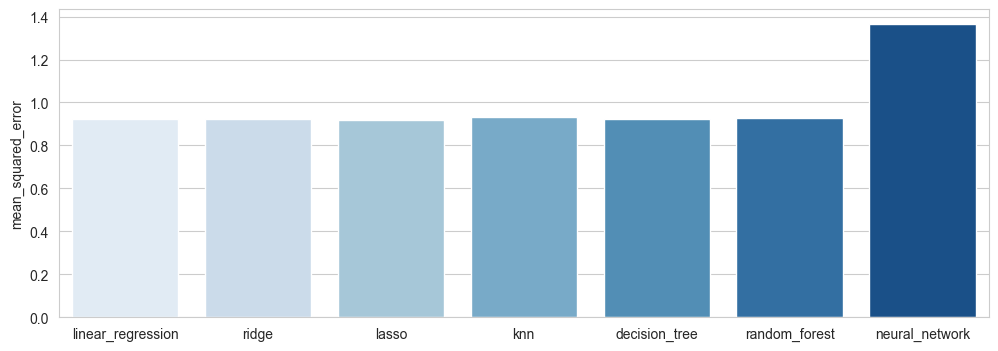

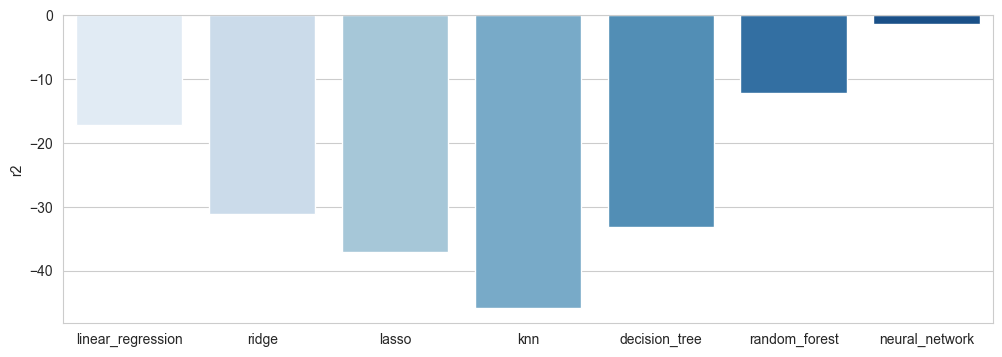

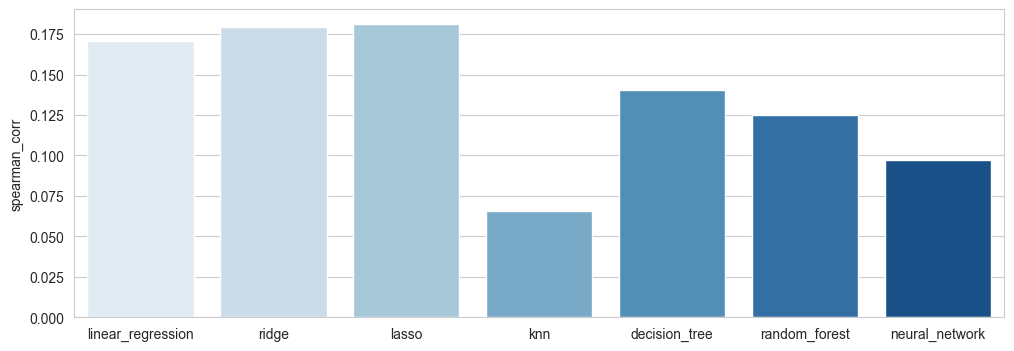

In [35]:
# Show, for each model, r2, mean error and spearman corr

spearman_corr = {}
mean_squared_error = {}
r2 = {}
for model in models:
    spearman_corr[model] = stats.spearmanr(models[model].predict(X_test), y_test)[0]
    mean_squared_error[model] = metrics.mean_squared_error(models[model].predict(X_test), y_test)
    r2[model] = metrics.r2_score(models[model].predict(X_test), y_test)

plt.figure(figsize=(12, 4))
sns.barplot(x=list(models.keys()), y=[mean_squared_error[model] for model in models], palette='Blues')
plt.ylabel('mean_squared_error')

plt.figure(figsize=(12, 4))
sns.barplot(x=list(models.keys()), y=[r2[model] for model in models], palette='Blues')
plt.ylabel('r2')

plt.figure(figsize=(12, 4))
sns.barplot(x=list(models.keys()), y=[spearman_corr[model] for model in models], palette='Blues')
plt.ylabel('spearman_corr')



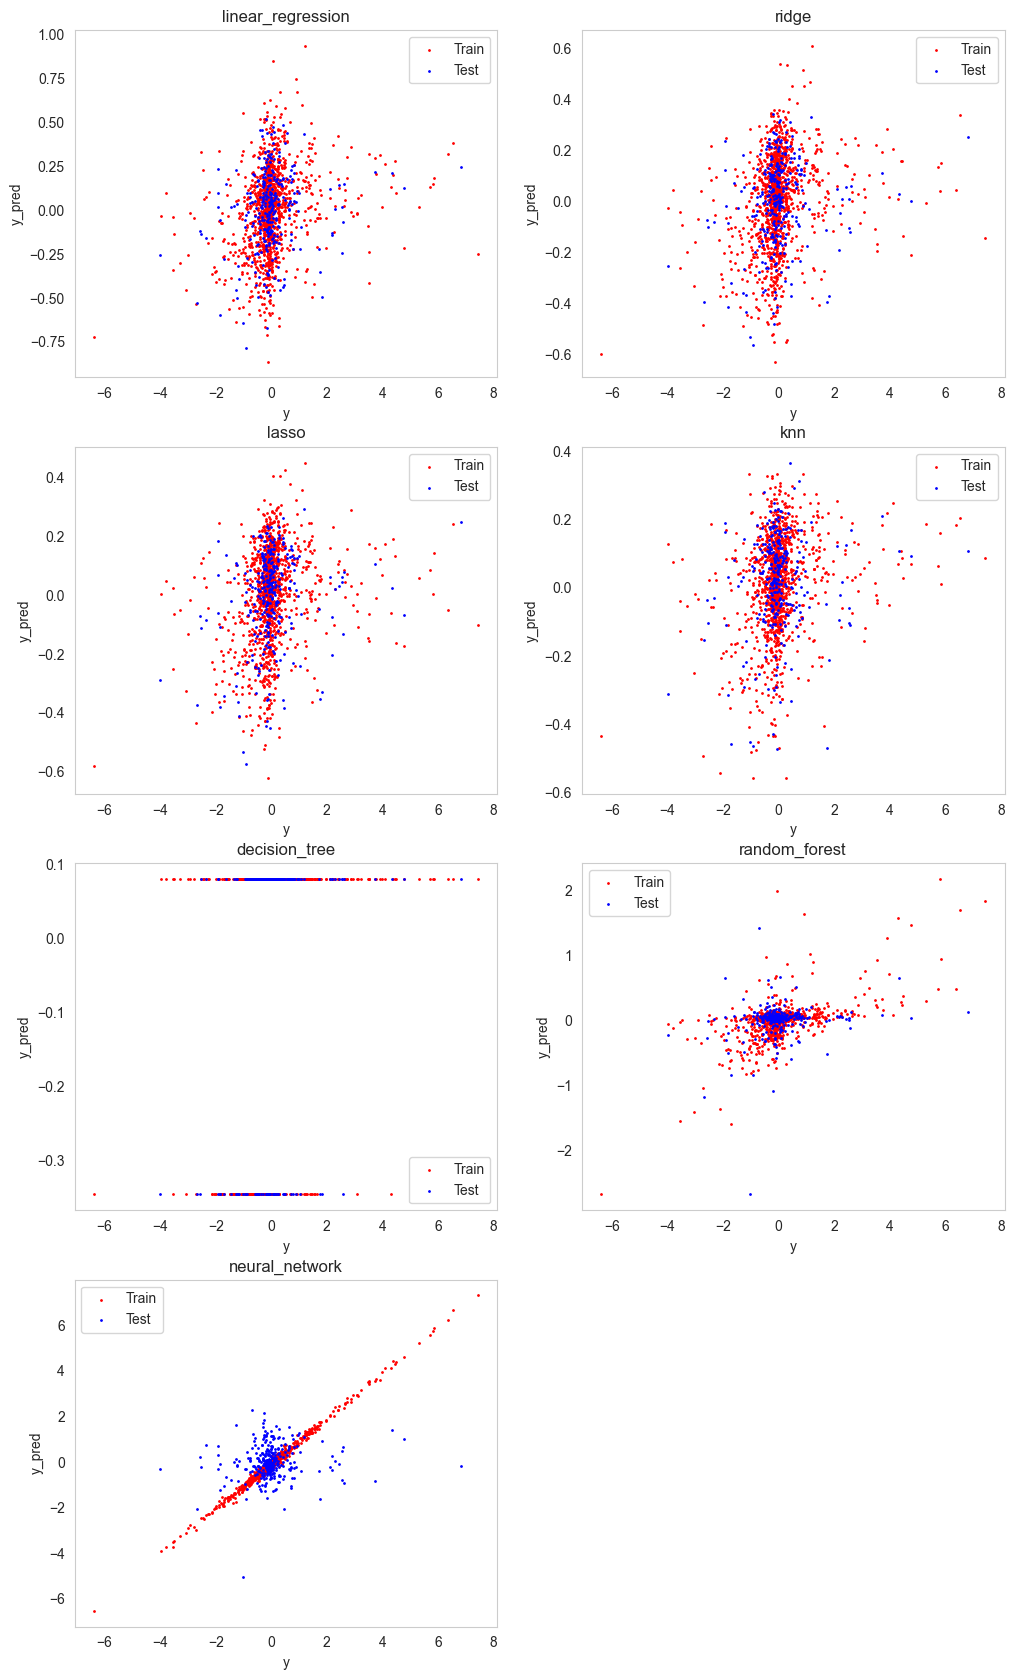

In [36]:
# Show y and y_pred for each model
plt.figure(figsize=(12, 64))

for i, model in enumerate(models):
    plt.subplot(12, 2, i+1)
    plt.scatter(y_train, models[model].predict(X_train), s=1, color='red', label='Train')
    plt.scatter(y_test, models[model].predict(X_test), s=1, color='blue', label='Test')
    plt.xlabel('y')
    plt.ylabel('y_pred')
    plt.title(model)
    plt.legend()
    plt.grid()

plt.show()
